In [1]:
import sys
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot-py39/lib/python3.9/site-packages')
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
# import joblib
# from joblib import dump, load

# print ( "numpy: {}".format(np.__version__) )
# print ( "joblib: {}".format(joblib.__version__) )

# import sklearn
# import tensorflow as tf
# from tensorflow import keras

# print ( "sklearn: {}".format(sklearn.__version__) )
# print ( "tensorflow: {}".format(tf.__version__) )

['/eos/home-i01/a/antoniov/SWAN_projects/pps-dilepton-analysis', '/cvmfs/sft.cern.ch/lcg/releases/condor/23.0.2-81e01/x86_64-el9-gcc13-opt/lib/python3', '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/itk', '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages', '/usr/local/lib/swan/nb_term_lib', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc13-opt/lib/python311.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc13-opt/lib/python3.11', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc13-opt/lib/python3.11/lib-dynload', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc13-opt/lib/python3.11/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11

In [2]:
# get_data, process_data, fiducial_cuts, fiducial_cuts_all, aperture_parametrisation, check_aperture
from processing import *
# efficiencies_2017
from proton_efficiency import *

#proton_selection = "SingleRP"
proton_selection = "MultiRP"

#data_periods = [ "2017B", "2017C1", "2017C2", "2017D", "2017E", "2017F1", "2017F2", "2017F3" ]
# data_periods = [ "2017B", "2017C1", "2017E", "2017F1" ]
data_periods = [ "2018A" ]

# run_tables = False

run_random_experiments = False


{'muon': {'2017B': 4.799881474, '2017C1': 5.785813941, '2017C2': 3.786684323, '2017D': 4.247682053, '2017E': 9.312832062, '2017F1': 1.738905587, '2017F2': 8.125575961, '2017F3': 3.674404546}, 'electron': {'2017B': 4.594096155565198, '2017C1': 5.521298099245362, '2017C2': 3.6135646891210857, '2017D': 4.0518639103567, '2017E': 8.906848461089172, '2017F1': 1.6584516422062712, '2017F2': 7.749629938012412, '2017F3': 3.504400870870218}}
Luminosity 2017 muon: 41.471779946999995
Luminosity 2017 electron: 39.60015376646642
{'muon': {'2018A': 14.025827145867588, '2018B1': 6.620869367493728, '2018B2': 0.430376623828928, '2018C': 6.891684998276784, '2018D1': 20.939902986506983, '2018D2': 10.856932131702669}, 'electron': {'2018A': 13.088399561509418, '2018B1': 6.629521091507798, '2018B2': 0.430939012174748, '2018C': 6.8915954055654725, '2018D1': 20.94983928140255, '2018D2': 10.862083907209522}}
Luminosity 2018 muon: 59.76559325367668
Luminosity 2018 electron: 58.85237825936951


### Event selection

In [3]:
def select_events( df ):
    msk_evts_ = ( ( df["Muon0Pt"] >= 50. ) & ( df["Muon1Pt"] >= 50. ) & ( df["InvMass"] >= 110. ) & ( df["Acopl"] <= 0.009 ) & ( df["ExtraPfCands"] <= 1 ) )
    df = df.loc[ msk_evts_ ]
    msk1_ = ( ( df["Arm"] == 0 ) & ( df.loc[ :, "Xi"] >= 0.045 ) )
    # msk1_ = ( ( df["Arm"] == 0 ) & ( df.loc[ :, "Xi"] >= 0.040 ) )
    msk2_ = ( ( df["Arm"] == 1 ) & ( df.loc[ :, "Xi"] >= 0.050 ) )
    # msk2_ = ( ( df["Arm"] == 1 ) & ( df.loc[ :, "Xi"] >= 0.040 ) )
    msk_ = ( msk1_ | msk2_ )
    df = df.loc[ msk_ ]

    return df

## Signal

In [4]:
labels_signals = [
    'GGToMuMu_Pt-25_Elastic',
    'GGToMuMu_Pt-25_Inel-El',
    'GGToMuMu_Pt-25_Inel-Inel'
]

df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_xiMax_multiRP = {}
df_signals_protons_multiRP_events = {}

base_path_ = "output"
for label_ in labels_signals:
    print ( label_ )
    file_path_ = "data-store-test-{}.h5".format( label_ )
    if base_path_ is not None and base_path_ != "": file_path_ = "{}/{}".format( base_path_, file_path_ )
        
    with pd.HDFStore( file_path_, 'r' ) as store_:
        print ( list( store_ ) )
        df_counts_signals[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_xiMax_multiRP[ label_ ] = store_[ "protons_xiMax_multiRP" ]
        df_signals_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]


GGToMuMu_Pt-25_Elastic
['/counts', '/events_multiRP', '/protons_multiRP', '/protons_xiMax_multiRP']
GGToMuMu_Pt-25_Inel-El
['/counts', '/events_multiRP', '/protons_multiRP', '/protons_xiMax_multiRP']
GGToMuMu_Pt-25_Inel-Inel
['/counts', '/events_multiRP', '/protons_multiRP', '/protons_xiMax_multiRP']


In [5]:
df_counts_signals

{'GGToMuMu_Pt-25_Elastic': All                   442360
 Muon                  275392
 Vertex                243030
 Protons_check_none    243030
 Protons                64491
 dtype: int64,
 'GGToMuMu_Pt-25_Inel-El': All                   442350
 Muon                  340920
 Vertex                304204
 Protons_check_none    304204
 Protons                45503
 dtype: int64,
 'GGToMuMu_Pt-25_Inel-Inel': All                   411016
 Muon                  103438
 Vertex                 92662
 Protons_check_none     92662
 Protons                 2748
 dtype: int64}

In [6]:
df_signals_protons_multiRP_index

{'GGToMuMu_Pt-25_Elastic':                                                                BX  \
 Run LumiSection EventNum hash_id              Slice                 
 1   3163        20       5802560787500170836  0      4.294967e+09   
                 35       7798140895750552703  0      4.294967e+09   
                 40       8590445763415350287  0      4.294967e+09   
                 27       1451513607787476364  0      4.294967e+09   
                 37       9509324156974304215  0      4.294967e+09   
 ...                                                           ...   
     4712        3058     16461815124216853638 0      4.294967e+09   
                 3073     14398466536404224567 0      4.294967e+09   
                 3084     2066367373011800241  0      4.294967e+09   
                 3065     16312323239835222705 0      4.294967e+09   
                 3093     843988394879476300   0      4.294967e+09   
 
                                                      Crossing

In [7]:
 df_signals_protons_xiMax_multiRP

{'GGToMuMu_Pt-25_Elastic':                                                                BX  \
 Run LumiSection EventNum hash_id              Slice                 
 1   3163        20       5802560787500170836  0      4.294967e+09   
                 35       7798140895750552703  0      4.294967e+09   
                 40       8590445763415350287  0      4.294967e+09   
                 27       1451513607787476364  0      4.294967e+09   
                 37       9509324156974304215  0      4.294967e+09   
 ...                                                           ...   
     4712        3058     16461815124216853638 0      4.294967e+09   
                 3073     14398466536404224567 0      4.294967e+09   
                 3084     2066367373011800241  0      4.294967e+09   
                 3065     16312323239835222705 0      4.294967e+09   
                 3093     843988394879476300   0      4.294967e+09   
 
                                                      Crossing

In [8]:
df_signals_protons_multiRP_events

{'GGToMuMu_Pt-25_Elastic':                                                                BX  \
 Run LumiSection EventNum hash_id              Slice                 
 1   3164        144      18255946901173027666 0      4.294967e+09   
     3165        218      15501759940499834067 0      4.294967e+09   
     3177        1432     8207489354913367955  0      4.294967e+09   
                 1453     5034887529932103874  0      4.294967e+09   
     3291        466      12452052126078434756 0      4.294967e+09   
 ...                                                           ...   
     4696        1429     18028916608810681374 0      4.294967e+09   
     4698        1676     11090974826354699518 0      4.294967e+09   
     4699        1777     13345940160539544451 0      4.294967e+09   
     4707        2556     18401399445317189344 0      4.294967e+09   
                 2585     5621434978826750825  0      4.294967e+09   
 
                                                      Crossing

In [9]:
label_ = 'GGToMuMu_Pt-25_Elastic'
df_signals_protons_multiRP_index[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   3163        20       5802560787500170836  0      4.294967e+09   
                35       7798140895750552703  0      4.294967e+09   
                40       8590445763415350287  0      4.294967e+09   
                27       1451513607787476364  0      4.294967e+09   
                37       9509324156974304215  0      4.294967e+09   
...                                                           ...   
    4712        3058     16461815124216853638 0      4.294967e+09   
                3073     14398466536404224567 0      4.294967e+09   
                3084     2066367373011800241  0      4.294967e+09   
                3065     16312323239835222705 0      4.294967e+09   
                3093     843988394879476300   0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   3163        20       5802560787500170836  0              152.0       0   
                35       7798140895750552703  0              152.0       0   
                40       8590445763415350287  0              152.0       0   
                27       1451513607787476364  0              152.0       0   
                37       9509324156974304215  0              152.0       0   
...                                                            ...     ...   
    4712        3058     16461815124216853638 0              130.0       0   
                3073     14398466536404224567 0              130.0       0   
                3084     2066367373011800241  0              130.0       0   
                3065     16312323239835222705 0              130.0       0   
                3093     843988394879476300   0              130.0       0   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   3163        20       5802560787500170836  0            1    0      3   
                35       7798140895750552703  0            1    1    103   
                40       8590445763415350287  0            1    1    103   
                27       1451513607787476364  0            1    0      3   
                37       9509324156974304215  0            1    1    103   
...                                                      ...  ...    ...   
    4712        3058     16461815124216853638 0            1    0      3   
                3073     14398466536404224567 0            1    1    103   
                3084     2066367373011800241  0            1    0      3   
                3065     16312323239835222705 0            1    1    103   
                3093     843988394879476300   0            1    0      3   

                                                     RPId2   TrackX1  \
Run LumiSection EventNum hash_id              Slice                    
1   3163        20       5802560787500170836  0         23  5.396423   
                35       7798140895750552703  0        123  4.659363   
                40       8590445763415350287  0        123  4.664917   
                27       1451513607787476364  0         23  4.861938   
                37       9509324156974304215  0        123  5.824524   
...                                                    ...       ...   
    4712        3058     16461815124216853638 0         23  8.656616   
                3073     14398466536404224567 0        123  3.899292   
                3084     2066367373011800241  0         23  4.335693   
                3065     16312323239835222705 0        123  7.351562   
                3093     843988394879476300   0         23  5.928223   

                                                      TrackY1   TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                      ...   
1   3163        20       5802560787500170836  0      1.101685  5

In [10]:
df_signals_protons_xiMax_multiRP[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   3163        20       5802560787500170836  0      4.294967e+09   
                35       7798140895750552703  0      4.294967e+09   
                40       8590445763415350287  0      4.294967e+09   
                27       1451513607787476364  0      4.294967e+09   
                37       9509324156974304215  0      4.294967e+09   
...                                                           ...   
    4712        3058     16461815124216853638 0      4.294967e+09   
                3073     14398466536404224567 0      4.294967e+09   
                3084     2066367373011800241  0      4.294967e+09   
                3065     16312323239835222705 0      4.294967e+09   
                3093     843988394879476300   0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   3163        20       5802560787500170836  0              152.0       0   
                35       7798140895750552703  0              152.0       0   
                40       8590445763415350287  0              152.0       0   
                27       1451513607787476364  0              152.0       0   
                37       9509324156974304215  0              152.0       0   
...                                                            ...     ...   
    4712        3058     16461815124216853638 0              130.0       0   
                3073     14398466536404224567 0              130.0       0   
                3084     2066367373011800241  0              130.0       0   
                3065     16312323239835222705 0              130.0       0   
                3093     843988394879476300   0              130.0       0   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   3163        20       5802560787500170836  0            1    0      3   
                35       7798140895750552703  0            1    1    103   
                40       8590445763415350287  0            1    1    103   
                27       1451513607787476364  0            1    0      3   
                37       9509324156974304215  0            1    1    103   
...                                                      ...  ...    ...   
    4712        3058     16461815124216853638 0            1    0      3   
                3073     14398466536404224567 0            1    1    103   
                3084     2066367373011800241  0            1    0      3   
                3065     16312323239835222705 0            1    1    103   
                3093     843988394879476300   0            1    0      3   

                                                     RPId2   TrackX1  \
Run LumiSection EventNum hash_id              Slice                    
1   3163        20       5802560787500170836  0         23  5.396423   
                35       7798140895750552703  0        123  4.659363   
                40       8590445763415350287  0        123  4.664917   
                27       1451513607787476364  0         23  4.861938   
                37       9509324156974304215  0        123  5.824524   
...                                                    ...       ...   
    4712        3058     16461815124216853638 0         23  8.656616   
                3073     14398466536404224567 0        123  3.899292   
                3084     2066367373011800241  0         23  4.335693   
                3065     16312323239835222705 0        123  7.351562   
                3093     843988394879476300   0         23  5.928223   

                                                      TrackY1   TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                      ...   
1   3163        20       5802560787500170836  0      1.101685  5

In [11]:
# groupby_ = df_signals_protons_multiRP_index[ label_ ].groupby( ['Run', 'LumiSection', 'EventNum', 'hash_id', 'Slice' ] )
# # gb_ = groupby_.groups
# # for key_, values_ in gb_.items():
# #     print ( key_, values_ )
# #     print( df_signals_protons_multiRP_events[ label_ ][ [ 'Xi', 'Arm' ] ].loc[ values_ ], "\n\n")
# msk_ = groupby_[ 'Xi' ].transform( lambda s_: s_.size > 1 )
# print ( msk_, np.sum(msk_) )

In [12]:
# df_signals_protons_multiRP_index[ label_ ][ msk_ ][ 'Xi' ]

In [13]:
df_signals_protons_multiRP_index[ label_ ][
    ['MultiRP', 'Arm', 'RPId1', 'RPId2',
     'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
     'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP',
     'Xi', 'T', 'ThX', 'ThY'] ]

MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   3163        20       5802560787500170836  0            1    0      3   
                35       7798140895750552703  0            1    1    103   
                40       8590445763415350287  0            1    1    103   
                27       1451513607787476364  0            1    0      3   
                37       9509324156974304215  0            1    1    103   
...                                                      ...  ...    ...   
    4712        3058     16461815124216853638 0            1    0      3   
                3073     14398466536404224567 0            1    1    103   
                3084     2066367373011800241  0            1    0      3   
                3065     16312323239835222705 0            1    1    103   
                3093     843988394879476300   0            1    0      3   

                                                     RPId2   TrackX1  \
Run LumiSection EventNum hash_id              Slice                    
1   3163        20       5802560787500170836  0         23  5.396423   
                35       7798140895750552703  0        123  4.659363   
                40       8590445763415350287  0        123  4.664917   
                27       1451513607787476364  0         23  4.861938   
                37       9509324156974304215  0        123  5.824524   
...                                                    ...       ...   
    4712        3058     16461815124216853638 0         23  8.656616   
                3073     14398466536404224567 0        123  3.899292   
                3084     2066367373011800241  0         23  4.335693   
                3065     16312323239835222705 0        123  7.351562   
                3093     843988394879476300   0         23  5.928223   

                                                      TrackY1   TrackX2  \
Run LumiSection EventNum hash_id              Slice                       
1   3163        20       5802560787500170836  0      1.101685  5.583130   
                35       7798140895750552703  0      1.636230  4.678467   
                40       8590445763415350287  0      2.141846  4.678467   
                27       1451513607787476364  0      1.632446  5.051758   
                37       9509324156974304215  0      3.163086  5.817078   
...                                                       ...       ...   
    4712        3058     16461815124216853638 0      1.357910  8.923096   
                3073     14398466536404224567 0      2.135254  3.919342   
                3084     2066367373011800241  0      1.558594  4.368530   
                3065     16312323239835222705 0      2.115479  7.487122   
                3093     843988394879476300   0      1.681396  5.962646   

                                                      TrackY2  \
Run LumiSection EventNum hash_id              Slice             
1   3163        20       5802560787500170836  0      1.050049   
                35       7798140895750552703  0      1.650024   
                40       8590445763415350287  0      2.250000   
                27       1451513607787476364  0      1.750000   
                37       9509324156974304215  0      3.350098   
...                                                       ...   
    4712        3058     16461815124216853638 0      1.449951   
                3073     14398466536404224567 0      2.350098   
                3084     2066367373011800241  0      1.750000   
                3065     16312323239835222705 0      2.149902   
                3093     843988394879476300   0      1.800049   

                                                     TrackThX_SingleRP  \
Run LumiSection EventNum hash_id              Slice                      
1   3163        20       5802560787500170836  0                 -999.0   
                35       7798140895750552703  0                 -999.0   
         

In [14]:
df_signals_protons_multiRP_events[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   3164        144      18255946901173027666 0      4.294967e+09   
    3165        218      15501759940499834067 0      4.294967e+09   
    3177        1432     8207489354913367955  0      4.294967e+09   
                1453     5034887529932103874  0      4.294967e+09   
    3291        466      12452052126078434756 0      4.294967e+09   
...                                                           ...   
    4696        1429     18028916608810681374 0      4.294967e+09   
    4698        1676     11090974826354699518 0      4.294967e+09   
    4699        1777     13345940160539544451 0      4.294967e+09   
    4707        2556     18401399445317189344 0      4.294967e+09   
                2585     5621434978826750825  0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   3164        144      18255946901173027666 0              152.0       0   
    3165        218      15501759940499834067 0              156.0       0   
    3177        1432     8207489354913367955  0              131.0       0   
                1453     5034887529932103874  0              131.0       0   
    3291        466      12452052126078434756 0              130.0       0   
...                                                            ...     ...   
    4696        1429     18028916608810681374 0              153.0       0   
    4698        1676     11090974826354699518 0              150.0       0   
    4699        1777     13345940160539544451 0              146.0       0   
    4707        2556     18401399445317189344 0              149.0       0   
                2585     5621434978826750825  0              149.0       0   

                                                        Muon0Pt  Muon0Eta  \
Run LumiSection EventNum hash_id              Slice                         
1   3164        144      18255946901173027666 0      128.844513 -1.440217   
    3165        218      15501759940499834067 0       63.080864  2.002017   
    3177        1432     8207489354913367955  0      264.600494 -0.139765   
                1453     5034887529932103874  0       88.953865  1.389837   
    3291        466      12452052126078434756 0       99.413223  1.276849   
...                                                         ...       ...   
    4696        1429     18028916608810681374 0      292.094238  0.267845   
    4698        1676     11090974826354699518 0      208.676620 -1.478488   
    4699        1777     13345940160539544451 0      447.189545  0.793853   
    4707        2556     18401399445317189344 0      148.849106  0.807094   
                2585     5621434978826750825  0       88.869858 -1.597581   

                                                     Muon0Phi  Muon0VtxZ  \
Run LumiSection EventNum hash_id              Slice                        
1   3164        144      18255946901173027666 0      0.120286  -0.361809   
    3165        218      15501759940499834067 0      0.815382  -2.885470   
    3177        1432     8207489354913367955  0     -1.082922   2.964515   
                1453     5034887529932103874  0     -0.214200   0.652533   
    3291        466      12452052126078434756 0      0.771814   3.192464   
...                                                       ...        ...   
    4696        1429     18028916608810681374 0      1.092380  -1.250863   
    4698        1676     11090974826354699518 0     -1.123589   8.477085   
    4699        1777     13345940160539544451 0      2.868685  -2.703990   
    4707        2556     18401399445317189344 0      0.349931   1.856806   
                2585     5621434978826750825  0      1.266296   3.645341   

                                                        Muon1Pt  Muon1Eta  \
Run LumiSection EventNum hash_id              Slice                         
1   3

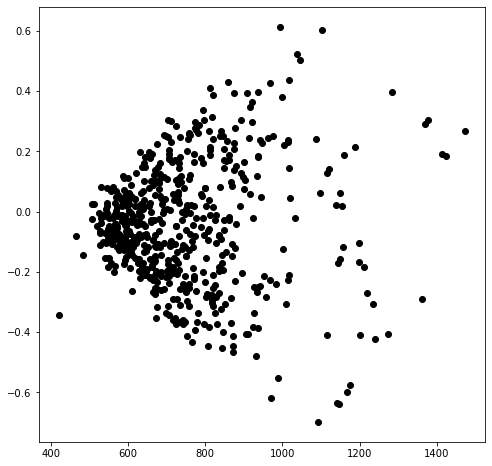

In [15]:
fig= plt.figure( figsize=(8,8) )
plt.plot( df_signals_protons_multiRP_events[ label_ ]['MX_nom'], df_signals_protons_multiRP_events[ label_ ]['YX_nom'], 'ko' )

In [16]:
label_ = 'GGToMuMu_Pt-25_Inel-El'
df_signals_protons_multiRP_index[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   222         2026     5517406040548304013  0      4.294967e+09   
                2049     13102802692205211257 0      4.294967e+09   
                2059     14916035373410583430 0      4.294967e+09   
                2075     13877805168805572346 0      4.294967e+09   
                2080     13777567606626590089 0      4.294967e+09   
...                                                           ...   
    419         1959     17714882431014843064 0      4.294967e+09   
                1985     1459481711850609917  0      4.294967e+09   
                1982     14652981473528389649 0      4.294967e+09   
                1995     13115338871090092894 0      4.294967e+09   
                1986     5956423337043843000  0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   222         2026     5517406040548304013  0              152.0       0   
                2049     13102802692205211257 0              152.0       0   
                2059     14916035373410583430 0              152.0       0   
                2075     13877805168805572346 0              152.0       0   
                2080     13777567606626590089 0              152.0       0   
...                                                            ...     ...   
    419         1959     17714882431014843064 0              152.0       0   
                1985     1459481711850609917  0              152.0       0   
                1982     14652981473528389649 0              152.0       0   
                1995     13115338871090092894 0              152.0       0   
                1986     5956423337043843000  0              152.0       0   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   222         2026     5517406040548304013  0            1    1    103   
                2049     13102802692205211257 0            1    0      3   
                2059     14916035373410583430 0            1    1    103   
                2075     13877805168805572346 0            1    0      3   
                2080     13777567606626590089 0            1    0      3   
...                                                      ...  ...    ...   
    419         1959     17714882431014843064 0            1    0      3   
                1985     1459481711850609917  0            1    0      3   
                1982     14652981473528389649 0            1    1    103   
                1995     13115338871090092894 0            1    0      3   
                1986     5956423337043843000  0            1    1    103   

                                                     RPId2   TrackX1  \
Run LumiSection EventNum hash_id              Slice                    
1   222         2026     5517406040548304013  0        123  3.483063   
                2049     13102802692205211257 0         23  4.403931   
                2059     14916035373410583430 0        123  5.777222   
                2075     13877805168805572346 0         23  6.309692   
                2080     13777567606626590089 0         23  6.476685   
...                                                    ...       ...   
    419         1959     17714882431014843064 0         23  4.178406   
                1985     1459481711850609917  0         23  5.196045   
                1982     14652981473528389649 0        123  3.647308   
                1995     13115338871090092894 0         23  4.314819   
                1986     5956423337043843000  0        123  4.546631   

                                                      TrackY1   TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                      ...   
1   222         2026     5517406040548304013  0      1.824341  3

In [17]:
df_signals_protons_multiRP_index[ label_ ][ 
    ['MultiRP', 'Arm', 'RPId1', 'RPId2',
     'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
     'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP',
     'Xi', 'T', 'ThX', 'ThY', 'random']
    ]

MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   222         2026     5517406040548304013  0            1    1    103   
                2049     13102802692205211257 0            1    0      3   
                2059     14916035373410583430 0            1    1    103   
                2075     13877805168805572346 0            1    0      3   
                2080     13777567606626590089 0            1    0      3   
...                                                      ...  ...    ...   
    419         1959     17714882431014843064 0            1    0      3   
                1985     1459481711850609917  0            1    0      3   
                1982     14652981473528389649 0            1    1    103   
                1995     13115338871090092894 0            1    0      3   
                1986     5956423337043843000  0            1    1    103   

                                                     RPId2   TrackX1  \
Run LumiSection EventNum hash_id              Slice                    
1   222         2026     5517406040548304013  0        123  3.483063   
                2049     13102802692205211257 0         23  4.403931   
                2059     14916035373410583430 0        123  5.777222   
                2075     13877805168805572346 0         23  6.309692   
                2080     13777567606626590089 0         23  6.476685   
...                                                    ...       ...   
    419         1959     17714882431014843064 0         23  4.178406   
                1985     1459481711850609917  0         23  5.196045   
                1982     14652981473528389649 0        123  3.647308   
                1995     13115338871090092894 0         23  4.314819   
                1986     5956423337043843000  0        123  4.546631   

                                                      TrackY1   TrackX2  \
Run LumiSection EventNum hash_id              Slice                       
1   222         2026     5517406040548304013  0      1.824341  3.539795   
                2049     13102802692205211257 0      1.618652  4.520386   
                2059     14916035373410583430 0      2.954590  6.044861   
                2075     13877805168805572346 0      2.239990  6.266296   
                2080     13777567606626590089 0      1.051514  6.190369   
...                                                       ...       ...   
    419         1959     17714882431014843064 0      1.586914  4.216736   
                1985     1459481711850609917  0      1.982422  5.279480   
                1982     14652981473528389649 0      1.746460  3.691620   
                1995     13115338871090092894 0      1.707031  4.368530   
                1986     5956423337043843000  0      2.983643  4.678467   

                                                      TrackY2  \
Run LumiSection EventNum hash_id              Slice             
1   222         2026     5517406040548304013  0      1.949951   
                2049     13102802692205211257 0      1.800049   
                2059     14916035373410583430 0      3.199951   
                2075     13877805168805572346 0      2.449951   
                2080     13777567606626590089 0      1.150024   
...                                                       ...   
    419         1959     17714882431014843064 0      1.699951   
                1985     1459481711850609917  0      2.149902   
                1982     14652981473528389649 0      1.800049   
                1995     13115338871090092894 0      1.949951   
                1986     5956423337043843000  0      3.300049   

                                                     TrackThX_SingleRP  \
Run LumiSection EventNum hash_id              Slice                      
1   222         2026     5517406040548304013  0                 -999.0   
                2049     13102802692205211257 0                 -999.0   
         

In [18]:
label_ = 'GGToMuMu_Pt-25_Inel-Inel'
df_signals_protons_multiRP_index[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   168         2349     10791132734101786942 0      4.294967e+09   
    125         1971     10799143482777226205 0      4.294967e+09   
    135         2924     810612397133455108   0      4.294967e+09   
    159         2211     15590971322028507974 0      4.294967e+09   
                2389     16187656537452156378 0      4.294967e+09   
...                                                           ...   
    50          1806     10707608777455023671 0      4.294967e+09   
                1831     16905964265320035438 0      4.294967e+09   
                1978     1757707364871217927  0      4.294967e+09   
                1975     4125211950031141916  0      4.294967e+09   
    66          2073     16302301018601257837 0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   168         2349     10791132734101786942 0              148.0       0   
    125         1971     10799143482777226205 0              133.0       0   
    135         2924     810612397133455108   0              143.0       0   
    159         2211     15590971322028507974 0              157.0       0   
                2389     16187656537452156378 0              157.0       0   
...                                                            ...     ...   
    50          1806     10707608777455023671 0              131.0       0   
                1831     16905964265320035438 0              131.0       0   
                1978     1757707364871217927  0              131.0       0   
                1975     4125211950031141916  0              131.0       0   
    66          2073     16302301018601257837 0              130.0       0   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   168         2349     10791132734101786942 0            1    0      3   
    125         1971     10799143482777226205 0            1    0      3   
    135         2924     810612397133455108   0            1    0      3   
    159         2211     15590971322028507974 0            1    0      3   
                2389     16187656537452156378 0            1    0      3   
...                                                      ...  ...    ...   
    50          1806     10707608777455023671 0            1    1    103   
                1831     16905964265320035438 0            1    1    103   
                1978     1757707364871217927  0            1    1    103   
                1975     4125211950031141916  0            1    1    103   
    66          2073     16302301018601257837 0            1    0      3   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   168         2349     10791132734101786942 0         23   6.878967   
    125         1971     10799143482777226205 0         23  12.546021   
    135         2924     810612397133455108   0         23   6.848328   
    159         2211     15590971322028507974 0         23  13.281006   
                2389     16187656537452156378 0         23   6.476685   
...                                                    ...        ...   
    50          1806     10707608777455023671 0        123   4.248657   
                1831     16905964265320035438 0        123   9.997803   
                1978     1757707364871217927  0        123  18.807861   
                1975     4125211950031141916  0        123   5.348450   
    66          2073     16302301018601257837 0         23   6.518433   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   168         2349     10791132734101786942 0  

In [19]:
df_signals_protons_multiRP_index[ label_ ][ 
    ['MultiRP', 'Arm', 'RPId1', 'RPId2',
     'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
     'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP',
     'Xi', 'T', 'ThX', 'ThY', 'random']
    ]

MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   168         2349     10791132734101786942 0            1    0      3   
    125         1971     10799143482777226205 0            1    0      3   
    135         2924     810612397133455108   0            1    0      3   
    159         2211     15590971322028507974 0            1    0      3   
                2389     16187656537452156378 0            1    0      3   
...                                                      ...  ...    ...   
    50          1806     10707608777455023671 0            1    1    103   
                1831     16905964265320035438 0            1    1    103   
                1978     1757707364871217927  0            1    1    103   
                1975     4125211950031141916  0            1    1    103   
    66          2073     16302301018601257837 0            1    0      3   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   168         2349     10791132734101786942 0         23   6.878967   
    125         1971     10799143482777226205 0         23  12.546021   
    135         2924     810612397133455108   0         23   6.848328   
    159         2211     15590971322028507974 0         23  13.281006   
                2389     16187656537452156378 0         23   6.476685   
...                                                    ...        ...   
    50          1806     10707608777455023671 0        123   4.248657   
                1831     16905964265320035438 0        123   9.997803   
                1978     1757707364871217927  0        123  18.807861   
                1975     4125211950031141916  0        123   5.348450   
    66          2073     16302301018601257837 0         23   6.518433   

                                                      TrackY1    TrackX2  \
Run LumiSection EventNum hash_id              Slice                        
1   168         2349     10791132734101786942 0      1.461548   6.797668   
    125         1971     10799143482777226205 0      1.500610  12.566772   
    135         2924     810612397133455108   0      0.043476   6.721741   
    159         2211     15590971322028507974 0      0.089180  13.174072   
                2389     16187656537452156378 0      1.051514   6.266296   
...                                                       ...        ...   
    50          1806     10707608777455023671 0      1.830933   4.526611   
                1831     16905964265320035438 0     -0.895508  10.295776   
                1978     1757707364871217927  0     -5.766602  19.253174   
                1975     4125211950031141916  0      2.187500   5.361633   
    66          2073     16302301018601257837 0      0.754456   6.494019   

                                                          TrackY2  \
Run LumiSection EventNum hash_id              Slice                 
1   168         2349     10791132734101786942 0      1.599976e+00   
    125         1971     10799143482777226205 0      1.699951e+00   
    135         2924     810612397133455108   0     -8.304050e-08   
    159         2211     15590971322028507974 0      2.499847e-01   
                2389     16187656537452156378 0      1.099976e+00   
...                                                           ...   
    50          1806     10707608777455023671 0      2.000000e+00   
                1831     16905964265320035438 0     -1.150024e+00   
                1978     1757707364871217927  0     -6.250000e+00   
                1975     4125211950031141916  0      2.300049e+00   
    66          2073     16302301018601257837 0      7.500000e-01   

                                                     TrackThX_SingleRP  \
Run LumiSection EventNum hash_id              Slice                      
1   168         2349     10791132734101786942 0                 -999.0   
    1

## Signal with mixed protons

In [20]:
df_signal_plus_mix_protons_multiRP = {}
df_signal_plus_mix_protons_xiMax_multiRP = {}
df_signal_plus_mix_protons_xiMax_multiRP_sig_protons = {}
df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons = {}
df_signal_plus_mix_events = {}

base_path_ = "output"
for label_ in labels_signals:
    print ( label_ )
    file_path_ = "/data-store-test-signal-plus-mix-events-{}.h5".format( label_ )
    if base_path_ is not None and base_path_ != "": file_path_ = "{}/{}".format( base_path_, file_path_ )
        
    with pd.HDFStore( file_path_, 'r' ) as store_:
        print ( list( store_ ) ) 
        df_signal_plus_mix_protons_multiRP[ label_ ] = store_[ "protons_multiRP" ]
        df_signal_plus_mix_protons_xiMax_multiRP[ label_ ] = store_[ "protons_xiMax_multiRP" ]
        df_signal_plus_mix_events[ label_ ] = store_[ "events_multiRP/all" ]

    msk_ = df_signal_plus_mix_protons_xiMax_multiRP[ label_ ].random == 0
    df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ] = df_signal_plus_mix_protons_xiMax_multiRP[ label_ ].loc[ msk_ ]
    msk_ = df_signal_plus_mix_protons_xiMax_multiRP[ label_ ].random == 1
    df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons[ label_ ] = df_signal_plus_mix_protons_xiMax_multiRP[ label_ ].loc[ msk_ ]

GGToMuMu_Pt-25_Elastic
['/protons_multiRP', '/protons_xiMax_multiRP', '/events_multiRP/1proton_sig_Arm0', '/events_multiRP/1proton_sig_Arm1', '/events_multiRP/2protons_mix', '/events_multiRP/2protons_sig', '/events_multiRP/all']
GGToMuMu_Pt-25_Inel-El
['/protons_multiRP', '/protons_xiMax_multiRP', '/events_multiRP/1proton_sig_Arm0', '/events_multiRP/1proton_sig_Arm1', '/events_multiRP/2protons_mix', '/events_multiRP/2protons_sig', '/events_multiRP/all']
GGToMuMu_Pt-25_Inel-Inel
['/protons_multiRP', '/protons_xiMax_multiRP', '/events_multiRP/1proton_sig_Arm0', '/events_multiRP/1proton_sig_Arm1', '/events_multiRP/2protons_mix', '/events_multiRP/2protons_sig', '/events_multiRP/all']


In [21]:
label_ = 'GGToMuMu_Pt-25_Elastic'
df_signal_plus_mix_protons_multiRP[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           1        15727814073996675721 0      4.294967e+09   
                4        8877239199479242098  0      4.294967e+09   
                                              0      4.294967e+09   
                5        2872528058510135165  0      4.294967e+09   
                6        15381907045478813310 0      4.294967e+09   
...                                                           ...   
    5000        895      6943800342089270447  0      4.294967e+09   
                                              0      4.294967e+09   
                896      2663238516988068327  0      4.294967e+09   
                897      6126280810026541697  0      4.294967e+09   
                                              0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           1        15727814073996675721 0              152.0       1   
                4        8877239199479242098  0              152.0       0   
                                              0              152.0       1   
                5        2872528058510135165  0              152.0       1   
                6        15381907045478813310 0              152.0       1   
...                                                            ...     ...   
    5000        895      6943800342089270447  0              153.0       1   
                                              0              153.0       1   
                896      2663238516988068327  0              153.0       1   
                897      6126280810026541697  0              153.0       0   
                                              0              153.0       1   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           1        15727814073996675721 0            1    1    103   
                4        8877239199479242098  0            1    1    103   
                                              0            1    0      3   
                5        2872528058510135165  0            1    1    103   
                6        15381907045478813310 0            1    1    103   
...                                                      ...  ...    ...   
    5000        895      6943800342089270447  0            1    0      3   
                                              0            1    1    103   
                896      2663238516988068327  0            1    1    103   
                897      6126280810026541697  0            1    1    103   
                                              0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           1        15727814073996675721 0        123   5.074219   
                4        8877239199479242098  0        123   3.435730   
                                              0         23  13.738647   
                5        2872528058510135165  0        123   5.920837   
                6        15381907045478813310 0        123   7.011353   
...                                                    ...        ...   
    5000        895      6943800342089270447  0         23  15.619385   
                                              0        123   6.728577   
                896      2663238516988068327  0        123  10.264404   
                897      6126280810026541697  0        123   4.030151   
                                              0        123   6.190674   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           1        15727814073996675721 0  

In [22]:
df_signal_plus_mix_protons_xiMax_multiRP[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           1        15727814073996675721 0      4.294967e+09   
                4        8877239199479242098  0      4.294967e+09   
                                              0      4.294967e+09   
                5        2872528058510135165  0      4.294967e+09   
                6        15381907045478813310 0      4.294967e+09   
...                                                           ...   
    5000        892      4146996855870624411  0      4.294967e+09   
                895      6943800342089270447  0      4.294967e+09   
                                              0      4.294967e+09   
                896      2663238516988068327  0      4.294967e+09   
                897      6126280810026541697  0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           1        15727814073996675721 0              152.0       1   
                4        8877239199479242098  0              152.0       0   
                                              0              152.0       1   
                5        2872528058510135165  0              152.0       1   
                6        15381907045478813310 0              152.0       1   
...                                                            ...     ...   
    5000        892      4146996855870624411  0              153.0       1   
                895      6943800342089270447  0              153.0       1   
                                              0              153.0       1   
                896      2663238516988068327  0              153.0       1   
                897      6126280810026541697  0              153.0       1   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           1        15727814073996675721 0            1    1    103   
                4        8877239199479242098  0            1    1    103   
                                              0            1    0      3   
                5        2872528058510135165  0            1    1    103   
                6        15381907045478813310 0            1    1    103   
...                                                      ...  ...    ...   
    5000        892      4146996855870624411  0            1    1    103   
                895      6943800342089270447  0            1    0      3   
                                              0            1    1    103   
                896      2663238516988068327  0            1    1    103   
                897      6126280810026541697  0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           1        15727814073996675721 0        123   5.074219   
                4        8877239199479242098  0        123   3.435730   
                                              0         23  13.738647   
                5        2872528058510135165  0        123   5.920837   
                6        15381907045478813310 0        123   9.562378   
...                                                    ...        ...   
    5000        892      4146996855870624411  0        123   8.657593   
                895      6943800342089270447  0         23  13.098755   
                                              0        123   6.728577   
                896      2663238516988068327  0        123  10.264404   
                897      6126280810026541697  0        123   6.190674   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           1        15727814073996675721 0  

In [23]:
df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           4        8877239199479242098  0      4.294967e+09   
                22       11957597614479949338 0      4.294967e+09   
                26       6073109419365364599  0      4.294967e+09   
                33       1827171435924839780  0      4.294967e+09   
                57       9167733517588960843  0      4.294967e+09   
...                                                           ...   
    4999        786      2051271016603498112  0      4.294967e+09   
    5000        803      10337848518774023852 0      4.294967e+09   
                836      7823181424059976497  0      4.294967e+09   
                869      8412979126155347252  0      4.294967e+09   
                872      6755464351330488899  0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           4        8877239199479242098  0              152.0       0   
                22       11957597614479949338 0              152.0       0   
                26       6073109419365364599  0              152.0       0   
                33       1827171435924839780  0              152.0       0   
                57       9167733517588960843  0              152.0       0   
...                                                            ...     ...   
    4999        786      2051271016603498112  0              141.0       0   
    5000        803      10337848518774023852 0              153.0       0   
                836      7823181424059976497  0              153.0       0   
                869      8412979126155347252  0              153.0       0   
                872      6755464351330488899  0              153.0       0   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           4        8877239199479242098  0            1    1    103   
                22       11957597614479949338 0            1    0      3   
                26       6073109419365364599  0            1    1    103   
                33       1827171435924839780  0            1    0      3   
                57       9167733517588960843  0            1    0      3   
...                                                      ...  ...    ...   
    4999        786      2051271016603498112  0            1    0      3   
    5000        803      10337848518774023852 0            1    0      3   
                836      7823181424059976497  0            1    0      3   
                869      8412979126155347252  0            1    1    103   
                872      6755464351330488899  0            1    1    103   

                                                     RPId2   TrackX1  \
Run LumiSection EventNum hash_id              Slice                    
1   1           4        8877239199479242098  0        123  3.435730   
                22       11957597614479949338 0         23  6.434937   
                26       6073109419365364599  0        123  4.276489   
                33       1827171435924839780  0         23  6.686890   
                57       9167733517588960843  0         23  4.239685   
...                                                    ...       ...   
    4999        786      2051271016603498112  0         23  5.332458   
    5000        803      10337848518774023852 0         23  5.299011   
                836      7823181424059976497  0         23  4.218811   
                869      8412979126155347252  0        123  5.217590   
                872      6755464351330488899  0        123  2.977722   

                                                      TrackY1   TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                      ...   
1   1           4        8877239199479242098  0      1.615723  3

In [24]:
df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           1        15727814073996675721 0      4.294967e+09   
                4        8877239199479242098  0      4.294967e+09   
                5        2872528058510135165  0      4.294967e+09   
                6        15381907045478813310 0      4.294967e+09   
                8        7089376998852400581  0      4.294967e+09   
...                                                           ...   
    5000        892      4146996855870624411  0      4.294967e+09   
                895      6943800342089270447  0      4.294967e+09   
                                              0      4.294967e+09   
                896      2663238516988068327  0      4.294967e+09   
                897      6126280810026541697  0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           1        15727814073996675721 0              152.0       1   
                4        8877239199479242098  0              152.0       1   
                5        2872528058510135165  0              152.0       1   
                6        15381907045478813310 0              152.0       1   
                8        7089376998852400581  0              152.0       1   
...                                                            ...     ...   
    5000        892      4146996855870624411  0              153.0       1   
                895      6943800342089270447  0              153.0       1   
                                              0              153.0       1   
                896      2663238516988068327  0              153.0       1   
                897      6126280810026541697  0              153.0       1   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           1        15727814073996675721 0            1    1    103   
                4        8877239199479242098  0            1    0      3   
                5        2872528058510135165  0            1    1    103   
                6        15381907045478813310 0            1    1    103   
                8        7089376998852400581  0            1    0      3   
...                                                      ...  ...    ...   
    5000        892      4146996855870624411  0            1    1    103   
                895      6943800342089270447  0            1    0      3   
                                              0            1    1    103   
                896      2663238516988068327  0            1    1    103   
                897      6126280810026541697  0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           1        15727814073996675721 0        123   5.074219   
                4        8877239199479242098  0         23  13.738647   
                5        2872528058510135165  0        123   5.920837   
                6        15381907045478813310 0        123   9.562378   
                8        7089376998852400581  0         23  15.886475   
...                                                    ...        ...   
    5000        892      4146996855870624411  0        123   8.657593   
                895      6943800342089270447  0         23  13.098755   
                                              0        123   6.728577   
                896      2663238516988068327  0        123  10.264404   
                897      6126280810026541697  0        123   6.190674   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           1        15727814073996675721 0  

In [25]:
label_ = 'GGToMuMu_Pt-25_Inel-El'
df_signal_plus_mix_protons_multiRP[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           2        3248880339869650575  0      4.294967e+09   
                4        13923716205603124331 0      4.294967e+09   
                6        6942292723038959089  0      4.294967e+09   
                7        7355804522719030473  0      4.294967e+09   
                8        5726067137351061315  0      4.294967e+09   
...                                                           ...   
    500         1997     5320375775658898512  0      4.294967e+09   
                                              0      4.294967e+09   
                1998     523400799123964040   0      4.294967e+09   
                2000     8900443736537612442  0      4.294967e+09   
                                              0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           2        3248880339869650575  0              152.0       1   
                4        13923716205603124331 0              152.0       1   
                6        6942292723038959089  0              152.0       1   
                7        7355804522719030473  0              152.0       1   
                8        5726067137351061315  0              152.0       1   
...                                                            ...     ...   
    500         1997     5320375775658898512  0              130.0       1   
                                              0              130.0       1   
                1998     523400799123964040   0              130.0       0   
                2000     8900443736537612442  0              130.0       0   
                                              0              130.0       1   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           2        3248880339869650575  0            1    0      3   
                4        13923716205603124331 0            1    1    103   
                6        6942292723038959089  0            1    0      3   
                7        7355804522719030473  0            1    1    103   
                8        5726067137351061315  0            1    0      3   
...                                                      ...  ...    ...   
    500         1997     5320375775658898512  0            1    0      3   
                                              0            1    0      3   
                1998     523400799123964040   0            1    1    103   
                2000     8900443736537612442  0            1    1    103   
                                              0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           2        3248880339869650575  0         23   3.515503   
                4        13923716205603124331 0        123   8.515137   
                6        6942292723038959089  0         23   3.939636   
                7        7355804522719030473  0        123   8.737915   
                8        5726067137351061315  0         23  14.369751   
...                                                    ...        ...   
    500         1997     5320375775658898512  0         23   3.420105   
                                              0         23  13.906616   
                1998     523400799123964040   0        123   3.551270   
                2000     8900443736537612442  0        123   5.590576   
                                              0        123  11.130127   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           2        3248880339869650575  0  

In [26]:
df_signal_plus_mix_protons_xiMax_multiRP[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           2        3248880339869650575  0      4.294967e+09   
                4        13923716205603124331 0      4.294967e+09   
                6        6942292723038959089  0      4.294967e+09   
                7        7355804522719030473  0      4.294967e+09   
                8        5726067137351061315  0      4.294967e+09   
...                                                           ...   
    500         1996     12237244058296612884 0      4.294967e+09   
                                              0      4.294967e+09   
                1997     5320375775658898512  0      4.294967e+09   
                1998     523400799123964040   0      4.294967e+09   
                2000     8900443736537612442  0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           2        3248880339869650575  0              152.0       1   
                4        13923716205603124331 0              152.0       1   
                6        6942292723038959089  0              152.0       1   
                7        7355804522719030473  0              152.0       1   
                8        5726067137351061315  0              152.0       1   
...                                                            ...     ...   
    500         1996     12237244058296612884 0              130.0       1   
                                              0              130.0       1   
                1997     5320375775658898512  0              130.0       1   
                1998     523400799123964040   0              130.0       0   
                2000     8900443736537612442  0              130.0       1   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           2        3248880339869650575  0            1    0      3   
                4        13923716205603124331 0            1    1    103   
                6        6942292723038959089  0            1    0      3   
                7        7355804522719030473  0            1    1    103   
                8        5726067137351061315  0            1    0      3   
...                                                      ...  ...    ...   
    500         1996     12237244058296612884 0            1    0      3   
                                              0            1    1    103   
                1997     5320375775658898512  0            1    0      3   
                1998     523400799123964040   0            1    1    103   
                2000     8900443736537612442  0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           2        3248880339869650575  0         23   3.515503   
                4        13923716205603124331 0        123   8.515137   
                6        6942292723038959089  0         23   3.939636   
                7        7355804522719030473  0        123   8.737915   
                8        5726067137351061315  0         23  14.369751   
...                                                    ...        ...   
    500         1996     12237244058296612884 0         23   8.923218   
                                              0        123   7.163330   
                1997     5320375775658898512  0         23  13.906616   
                1998     523400799123964040   0        123   3.551270   
                2000     8900443736537612442  0        123  11.130127   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           2        3248880339869650575  0  

In [27]:
df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           22       14375974643974397545 0      4.294967e+09   
                25       6629073143940057040  0      4.294967e+09   
                45       12236195410975770477 0      4.294967e+09   
                59       9231631927754475110  0      4.294967e+09   
                80       13696300213981571301 0      4.294967e+09   
...                                                           ...   
    500         1977     9586436145901161435  0      4.294967e+09   
                1978     14535320156837403161 0      4.294967e+09   
                1980     12843125793573554177 0      4.294967e+09   
                1995     13316581837414198075 0      4.294967e+09   
                1998     523400799123964040   0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           22       14375974643974397545 0              152.0       0   
                25       6629073143940057040  0              152.0       0   
                45       12236195410975770477 0              152.0       0   
                59       9231631927754475110  0              152.0       0   
                80       13696300213981571301 0              152.0       0   
...                                                            ...     ...   
    500         1977     9586436145901161435  0              130.0       0   
                1978     14535320156837403161 0              130.0       0   
                1980     12843125793573554177 0              130.0       0   
                1995     13316581837414198075 0              130.0       0   
                1998     523400799123964040   0              130.0       0   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           22       14375974643974397545 0            1    1    103   
                25       6629073143940057040  0            1    0      3   
                45       12236195410975770477 0            1    0      3   
                59       9231631927754475110  0            1    0      3   
                80       13696300213981571301 0            1    1    103   
...                                                      ...  ...    ...   
    500         1977     9586436145901161435  0            1    0      3   
                1978     14535320156837403161 0            1    1    103   
                1980     12843125793573554177 0            1    1    103   
                1995     13316581837414198075 0            1    0      3   
                1998     523400799123964040   0            1    1    103   

                                                     RPId2   TrackX1  \
Run LumiSection EventNum hash_id              Slice                    
1   1           22       14375974643974397545 0        123  5.131226   
                25       6629073143940057040  0         23  4.526428   
                45       12236195410975770477 0         23  4.253601   
                59       9231631927754475110  0         23  4.035034   
                80       13696300213981571301 0        123  4.266785   
...                                                    ...       ...   
    500         1977     9586436145901161435  0         23  5.436829   
                1978     14535320156837403161 0        123  7.499207   
                1980     12843125793573554177 0        123  6.166992   
                1995     13316581837414198075 0         23  4.853577   
                1998     523400799123964040   0        123  3.551270   

                                                      TrackY1   TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                      ...   
1   1           22       14375974643974397545 0      1.551025  4

In [28]:
df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           2        3248880339869650575  0      4.294967e+09   
                4        13923716205603124331 0      4.294967e+09   
                6        6942292723038959089  0      4.294967e+09   
                7        7355804522719030473  0      4.294967e+09   
                8        5726067137351061315  0      4.294967e+09   
...                                                           ...   
    500         1989     808666090055505086   0      4.294967e+09   
                1996     12237244058296612884 0      4.294967e+09   
                                              0      4.294967e+09   
                1997     5320375775658898512  0      4.294967e+09   
                2000     8900443736537612442  0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           2        3248880339869650575  0              152.0       1   
                4        13923716205603124331 0              152.0       1   
                6        6942292723038959089  0              152.0       1   
                7        7355804522719030473  0              152.0       1   
                8        5726067137351061315  0              152.0       1   
...                                                            ...     ...   
    500         1989     808666090055505086   0              130.0       1   
                1996     12237244058296612884 0              130.0       1   
                                              0              130.0       1   
                1997     5320375775658898512  0              130.0       1   
                2000     8900443736537612442  0              130.0       1   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           2        3248880339869650575  0            1    0      3   
                4        13923716205603124331 0            1    1    103   
                6        6942292723038959089  0            1    0      3   
                7        7355804522719030473  0            1    1    103   
                8        5726067137351061315  0            1    0      3   
...                                                      ...  ...    ...   
    500         1989     808666090055505086   0            1    0      3   
                1996     12237244058296612884 0            1    0      3   
                                              0            1    1    103   
                1997     5320375775658898512  0            1    0      3   
                2000     8900443736537612442  0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           2        3248880339869650575  0         23   3.515503   
                4        13923716205603124331 0        123   8.515137   
                6        6942292723038959089  0         23   3.939636   
                7        7355804522719030473  0        123   8.737915   
                8        5726067137351061315  0         23  14.369751   
...                                                    ...        ...   
    500         1989     808666090055505086   0         23  13.859131   
                1996     12237244058296612884 0         23   8.923218   
                                              0        123   7.163330   
                1997     5320375775658898512  0         23  13.906616   
                2000     8900443736537612442  0        123  11.130127   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           2        3248880339869650575  0  

In [29]:
label_ = 'GGToMuMu_Pt-25_Inel-Inel'
df_signal_plus_mix_protons_multiRP[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           1        7381756517428643030  0      4.294967e+09   
                                              0      4.294967e+09   
                                              0      4.294967e+09   
                4        7017272557884440158  0      4.294967e+09   
                                              0      4.294967e+09   
...                                                           ...   
    494         1803     17193676594913358180 0      4.294967e+09   
                                              0      4.294967e+09   
    495         2175     11458497797051166589 0      4.294967e+09   
    499         715      2457829595646100812  0      4.294967e+09   
                                              0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           1        7381756517428643030  0              152.0       1   
                                              0              152.0       1   
                                              0              152.0       1   
                4        7017272557884440158  0              152.0       1   
                                              0              152.0       1   
...                                                            ...     ...   
    494         1803     17193676594913358180 0              155.0       1   
                                              0              155.0       1   
    495         2175     11458497797051166589 0              152.0       1   
    499         715      2457829595646100812  0              150.0       1   
                                              0              150.0       1   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           1        7381756517428643030  0            1    0      3   
                                              0            1    0      3   
                                              0            1    0      3   
                4        7017272557884440158  0            1    0      3   
                                              0            1    1    103   
...                                                      ...  ...    ...   
    494         1803     17193676594913358180 0            1    1    103   
                                              0            1    1    103   
    495         2175     11458497797051166589 0            1    0      3   
    499         715      2457829595646100812  0            1    0      3   
                                              0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           1        7381756517428643030  0         23   7.677307   
                                              0         23  10.629150   
                                              0         23  12.526611   
                4        7017272557884440158  0         23   3.749115   
                                              0        123   3.291931   
...                                                    ...        ...   
    494         1803     17193676594913358180 0        123   3.039520   
                                              0        123   9.812134   
    495         2175     11458497797051166589 0         23   4.374084   
    499         715      2457829595646100812  0         23   4.486511   
                                              0        123   2.919922   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           1        7381756517428643030  0  

In [30]:
df_signal_plus_mix_protons_xiMax_multiRP[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           1        7381756517428643030  0      4.294967e+09   
                4        7017272557884440158  0      4.294967e+09   
                                              0      4.294967e+09   
                7        11948950788136801235 0      4.294967e+09   
                10       7078055607442621472  0      4.294967e+09   
...                                                           ...   
    491         1567     15503207257400889454 0      4.294967e+09   
    494         1803     17193676594913358180 0      4.294967e+09   
    495         2175     11458497797051166589 0      4.294967e+09   
    499         715      2457829595646100812  0      4.294967e+09   
                                              0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           1        7381756517428643030  0              152.0       1   
                4        7017272557884440158  0              152.0       1   
                                              0              152.0       1   
                7        11948950788136801235 0              152.0       1   
                10       7078055607442621472  0              152.0       1   
...                                                            ...     ...   
    491         1567     15503207257400889454 0              148.0       1   
    494         1803     17193676594913358180 0              155.0       1   
    495         2175     11458497797051166589 0              152.0       1   
    499         715      2457829595646100812  0              150.0       1   
                                              0              150.0       1   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           1        7381756517428643030  0            1    0      3   
                4        7017272557884440158  0            1    0      3   
                                              0            1    1    103   
                7        11948950788136801235 0            1    1    103   
                10       7078055607442621472  0            1    1    103   
...                                                      ...  ...    ...   
    491         1567     15503207257400889454 0            1    1    103   
    494         1803     17193676594913358180 0            1    1    103   
    495         2175     11458497797051166589 0            1    0      3   
    499         715      2457829595646100812  0            1    0      3   
                                              0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           1        7381756517428643030  0         23  12.526611   
                4        7017272557884440158  0         23   3.749115   
                                              0        123  13.281616   
                7        11948950788136801235 0        123   3.578949   
                10       7078055607442621472  0        123   8.494507   
...                                                    ...        ...   
    491         1567     15503207257400889454 0        123   7.928772   
    494         1803     17193676594913358180 0        123   9.812134   
    495         2175     11458497797051166589 0         23   4.374084   
    499         715      2457829595646100812  0         23   4.486511   
                                              0        123   2.919922   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           1        7381756517428643030  0  

In [31]:
df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           48       12068808605034131196 0      4.294967e+09   
                358      9477714266614955789  0      4.294967e+09   
                418      2793508693512245819  0      4.294967e+09   
    2           1332     11840882822381260769 0      4.294967e+09   
                1351     14586255724406883228 0      4.294967e+09   
...                                                           ...   
    468         2024     8602543744802694264  0      4.294967e+09   
    477         2363     1914677006740390836  0      4.294967e+09   
    490         94       18348624166551747967 0      4.294967e+09   
                200      12829728194331689326 0      4.294967e+09   
    491         1531     15878783905095202    0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           48       12068808605034131196 0              152.0       0   
                358      9477714266614955789  0              152.0       0   
                418      2793508693512245819  0              152.0       0   
    2           1332     11840882822381260769 0              152.0       0   
                1351     14586255724406883228 0              152.0       0   
...                                                            ...     ...   
    468         2024     8602543744802694264  0              130.0       0   
    477         2363     1914677006740390836  0              151.0       0   
    490         94       18348624166551747967 0              155.0       0   
                200      12829728194331689326 0              155.0       0   
    491         1531     15878783905095202    0              148.0       0   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           48       12068808605034131196 0            1    0      3   
                358      9477714266614955789  0            1    1    103   
                418      2793508693512245819  0            1    0      3   
    2           1332     11840882822381260769 0            1    1    103   
                1351     14586255724406883228 0            1    1    103   
...                                                      ...  ...    ...   
    468         2024     8602543744802694264  0            1    0      3   
    477         2363     1914677006740390836  0            1    0      3   
    490         94       18348624166551747967 0            1    0      3   
                200      12829728194331689326 0            1    0      3   
    491         1531     15878783905095202    0            1    0      3   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           48       12068808605034131196 0         23   4.895325   
                358      9477714266614955789  0        123   3.689056   
                418      2793508693512245819  0         23   8.716553   
    2           1332     11840882822381260769 0        123   3.386993   
                1351     14586255724406883228 0        123   3.243622   
...                                                    ...        ...   
    468         2024     8602543744802694264  0         23  10.361816   
    477         2363     1914677006740390836  0         23   6.462769   
    490         94       18348624166551747967 0         23  14.332031   
                200      12829728194331689326 0         23   9.124390   
    491         1531     15878783905095202    0         23  14.479492   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           48       12068808605034131196 0  

In [32]:
df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           1        7381756517428643030  0      4.294967e+09   
                4        7017272557884440158  0      4.294967e+09   
                                              0      4.294967e+09   
                7        11948950788136801235 0      4.294967e+09   
                10       7078055607442621472  0      4.294967e+09   
...                                                           ...   
    491         1567     15503207257400889454 0      4.294967e+09   
    494         1803     17193676594913358180 0      4.294967e+09   
    495         2175     11458497797051166589 0      4.294967e+09   
    499         715      2457829595646100812  0      4.294967e+09   
                                              0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           1        7381756517428643030  0              152.0       1   
                4        7017272557884440158  0              152.0       1   
                                              0              152.0       1   
                7        11948950788136801235 0              152.0       1   
                10       7078055607442621472  0              152.0       1   
...                                                            ...     ...   
    491         1567     15503207257400889454 0              148.0       1   
    494         1803     17193676594913358180 0              155.0       1   
    495         2175     11458497797051166589 0              152.0       1   
    499         715      2457829595646100812  0              150.0       1   
                                              0              150.0       1   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           1        7381756517428643030  0            1    0      3   
                4        7017272557884440158  0            1    0      3   
                                              0            1    1    103   
                7        11948950788136801235 0            1    1    103   
                10       7078055607442621472  0            1    1    103   
...                                                      ...  ...    ...   
    491         1567     15503207257400889454 0            1    1    103   
    494         1803     17193676594913358180 0            1    1    103   
    495         2175     11458497797051166589 0            1    0      3   
    499         715      2457829595646100812  0            1    0      3   
                                              0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           1        7381756517428643030  0         23  12.526611   
                4        7017272557884440158  0         23   3.749115   
                                              0        123  13.281616   
                7        11948950788136801235 0        123   3.578949   
                10       7078055607442621472  0        123   8.494507   
...                                                    ...        ...   
    491         1567     15503207257400889454 0        123   7.928772   
    494         1803     17193676594913358180 0        123   9.812134   
    495         2175     11458497797051166589 0         23   4.374084   
    499         715      2457829595646100812  0         23   4.486511   
                                              0        123   2.919922   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           1        7381756517428643030  0  

### Normalization of signal samples

In [33]:
# L_B  = 2.360904801;
# L_C1 = 5.313012839;
# L_E  = 8.958810514;
# L_F1 = 1.708478656;
# lumi_periods = {}
# lumi_periods[ "2017B" ]  = L_B
# lumi_periods[ "2017C1" ] = L_C1
# lumi_periods[ "2017E" ]  = L_E
# lumi_periods[ "2017F1" ] = L_F1
# print ( lumi_periods )
# np.sum( list( lumi_periods.values() ) )
print ( lumi_periods_2018 )
print ( "Luminosity 2018 muon: {}".format( np.sum( list( lumi_periods_2018[ 'muon' ].values() ) ) ) )
print ( "Luminosity 2018 electron: {}".format( np.sum( list( lumi_periods_2018[ 'electron' ].values() ) ) ) )

{'muon': {'2018A': 14.025827145867588, '2018B1': 6.620869367493728, '2018B2': 0.430376623828928, '2018C': 6.891684998276784, '2018D1': 20.939902986506983, '2018D2': 10.856932131702669}, 'electron': {'2018A': 13.088399561509418, '2018B1': 6.629521091507798, '2018B2': 0.430939012174748, '2018C': 6.8915954055654725, '2018D1': 20.94983928140255, '2018D2': 10.862083907209522}}
Luminosity 2018 muon: 59.76559325367668
Luminosity 2018 electron: 58.85237825936951


In [34]:
lumi_periods = lumi_periods_2018[ 'muon' ]
# lumi = np.sum( list( lumi_periods.values() ) )
lumi = lumi_periods['2018A'] + lumi_periods['2018B1'] + lumi_periods['2018B2']
print ( lumi )

norm_factors = {}
# norm_factors['Elastic'] = np.array( [ ( lumi / ( 200000 * test_sample_ratio ) ), 0.017254036*1000, 0.89 ] )
# norm_factors['SingleDissociation'] = np.array( [ ( lumi / ( 200000 * test_sample_ratio ) ), 0.025643100*1000, 0.76 ] )
norm_factors[ 'GGToMuMu_Pt-25_Elastic' ] = np.array( [ ( lumi / 500000 ), 0.11247885*1000, 0.89 ] )
norm_factors[ 'GGToMuMu_Pt-25_Inel-El' ] = np.array( [ ( lumi / 500000 ), 0.14633895*1000, 0.76 ] )
norm_factors[ 'GGToMuMu_Pt-25_Inel-Inel' ] = np.array( [ ( lumi / 500000 ), 0.304945*1000, 0.13 ] )
for label_ in labels_signals:
    # df_signals[ label_ ]["norm"] = np.product( norm_factors[ label_ ] )
    # df_signals_protons_multiRP_index[ label_ ]["norm"] = np.product( norm_factors[ label_ ] )
    df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ]["norm"] = np.product( norm_factors[ label_ ] )
    df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons[ label_ ]["norm"] = np.product( norm_factors[ label_ ] )

21.077073137190244


/tmp/ipykernel_633/1418802785.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ]["norm"] = np.product( norm_factors[ label_ ] )
/tmp/ipykernel_633/1418802785.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons[ label_ ]["norm"] = np.product( norm_factors[ label_ ] )
/tmp/ipykernel_633/1418802785.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [35]:
label_ = 'GGToMuMu_Pt-25_Elastic'
df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           4        8877239199479242098  0      4.294967e+09   
                22       11957597614479949338 0      4.294967e+09   
                26       6073109419365364599  0      4.294967e+09   
                33       1827171435924839780  0      4.294967e+09   
                57       9167733517588960843  0      4.294967e+09   
...                                                           ...   
    4999        786      2051271016603498112  0      4.294967e+09   
    5000        803      10337848518774023852 0      4.294967e+09   
                836      7823181424059976497  0      4.294967e+09   
                869      8412979126155347252  0      4.294967e+09   
                872      6755464351330488899  0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           4        8877239199479242098  0              152.0       0   
                22       11957597614479949338 0              152.0       0   
                26       6073109419365364599  0              152.0       0   
                33       1827171435924839780  0              152.0       0   
                57       9167733517588960843  0              152.0       0   
...                                                            ...     ...   
    4999        786      2051271016603498112  0              141.0       0   
    5000        803      10337848518774023852 0              153.0       0   
                836      7823181424059976497  0              153.0       0   
                869      8412979126155347252  0              153.0       0   
                872      6755464351330488899  0              153.0       0   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           4        8877239199479242098  0            1    1    103   
                22       11957597614479949338 0            1    0      3   
                26       6073109419365364599  0            1    1    103   
                33       1827171435924839780  0            1    0      3   
                57       9167733517588960843  0            1    0      3   
...                                                      ...  ...    ...   
    4999        786      2051271016603498112  0            1    0      3   
    5000        803      10337848518774023852 0            1    0      3   
                836      7823181424059976497  0            1    0      3   
                869      8412979126155347252  0            1    1    103   
                872      6755464351330488899  0            1    1    103   

                                                     RPId2   TrackX1  \
Run LumiSection EventNum hash_id              Slice                    
1   1           4        8877239199479242098  0        123  3.435730   
                22       11957597614479949338 0         23  6.434937   
                26       6073109419365364599  0        123  4.276489   
                33       1827171435924839780  0         23  6.686890   
                57       9167733517588960843  0         23  4.239685   
...                                                    ...       ...   
    4999        786      2051271016603498112  0         23  5.332458   
    5000        803      10337848518774023852 0         23  5.299011   
                836      7823181424059976497  0         23  4.218811   
                869      8412979126155347252  0        123  5.217590   
                872      6755464351330488899  0        123  2.977722   

                                                      TrackY1   TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                      ...   
1   1           4        8877239199479242098  0      1.615723  3

In [36]:
df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           1        15727814073996675721 0      4.294967e+09   
                4        8877239199479242098  0      4.294967e+09   
                5        2872528058510135165  0      4.294967e+09   
                6        15381907045478813310 0      4.294967e+09   
                8        7089376998852400581  0      4.294967e+09   
...                                                           ...   
    5000        892      4146996855870624411  0      4.294967e+09   
                895      6943800342089270447  0      4.294967e+09   
                                              0      4.294967e+09   
                896      2663238516988068327  0      4.294967e+09   
                897      6126280810026541697  0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           1        15727814073996675721 0              152.0       1   
                4        8877239199479242098  0              152.0       1   
                5        2872528058510135165  0              152.0       1   
                6        15381907045478813310 0              152.0       1   
                8        7089376998852400581  0              152.0       1   
...                                                            ...     ...   
    5000        892      4146996855870624411  0              153.0       1   
                895      6943800342089270447  0              153.0       1   
                                              0              153.0       1   
                896      2663238516988068327  0              153.0       1   
                897      6126280810026541697  0              153.0       1   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           1        15727814073996675721 0            1    1    103   
                4        8877239199479242098  0            1    0      3   
                5        2872528058510135165  0            1    1    103   
                6        15381907045478813310 0            1    1    103   
                8        7089376998852400581  0            1    0      3   
...                                                      ...  ...    ...   
    5000        892      4146996855870624411  0            1    1    103   
                895      6943800342089270447  0            1    0      3   
                                              0            1    1    103   
                896      2663238516988068327  0            1    1    103   
                897      6126280810026541697  0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           1        15727814073996675721 0        123   5.074219   
                4        8877239199479242098  0         23  13.738647   
                5        2872528058510135165  0        123   5.920837   
                6        15381907045478813310 0        123   9.562378   
                8        7089376998852400581  0         23  15.886475   
...                                                    ...        ...   
    5000        892      4146996855870624411  0        123   8.657593   
                895      6943800342089270447  0         23  13.098755   
                                              0        123   6.728577   
                896      2663238516988068327  0        123  10.264404   
                897      6126280810026541697  0        123   6.190674   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           1        15727814073996675721 0  

In [37]:
label_ = 'GGToMuMu_Pt-25_Inel-El'
df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           22       14375974643974397545 0      4.294967e+09   
                25       6629073143940057040  0      4.294967e+09   
                45       12236195410975770477 0      4.294967e+09   
                59       9231631927754475110  0      4.294967e+09   
                80       13696300213981571301 0      4.294967e+09   
...                                                           ...   
    500         1977     9586436145901161435  0      4.294967e+09   
                1978     14535320156837403161 0      4.294967e+09   
                1980     12843125793573554177 0      4.294967e+09   
                1995     13316581837414198075 0      4.294967e+09   
                1998     523400799123964040   0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           22       14375974643974397545 0              152.0       0   
                25       6629073143940057040  0              152.0       0   
                45       12236195410975770477 0              152.0       0   
                59       9231631927754475110  0              152.0       0   
                80       13696300213981571301 0              152.0       0   
...                                                            ...     ...   
    500         1977     9586436145901161435  0              130.0       0   
                1978     14535320156837403161 0              130.0       0   
                1980     12843125793573554177 0              130.0       0   
                1995     13316581837414198075 0              130.0       0   
                1998     523400799123964040   0              130.0       0   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           22       14375974643974397545 0            1    1    103   
                25       6629073143940057040  0            1    0      3   
                45       12236195410975770477 0            1    0      3   
                59       9231631927754475110  0            1    0      3   
                80       13696300213981571301 0            1    1    103   
...                                                      ...  ...    ...   
    500         1977     9586436145901161435  0            1    0      3   
                1978     14535320156837403161 0            1    1    103   
                1980     12843125793573554177 0            1    1    103   
                1995     13316581837414198075 0            1    0      3   
                1998     523400799123964040   0            1    1    103   

                                                     RPId2   TrackX1  \
Run LumiSection EventNum hash_id              Slice                    
1   1           22       14375974643974397545 0        123  5.131226   
                25       6629073143940057040  0         23  4.526428   
                45       12236195410975770477 0         23  4.253601   
                59       9231631927754475110  0         23  4.035034   
                80       13696300213981571301 0        123  4.266785   
...                                                    ...       ...   
    500         1977     9586436145901161435  0         23  5.436829   
                1978     14535320156837403161 0        123  7.499207   
                1980     12843125793573554177 0        123  6.166992   
                1995     13316581837414198075 0         23  4.853577   
                1998     523400799123964040   0        123  3.551270   

                                                      TrackY1   TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                      ...   
1   1           22       14375974643974397545 0      1.551025  4

In [38]:
label_ = 'GGToMuMu_Pt-25_Inel-Inel'
df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           48       12068808605034131196 0      4.294967e+09   
                358      9477714266614955789  0      4.294967e+09   
                418      2793508693512245819  0      4.294967e+09   
    2           1332     11840882822381260769 0      4.294967e+09   
                1351     14586255724406883228 0      4.294967e+09   
...                                                           ...   
    468         2024     8602543744802694264  0      4.294967e+09   
    477         2363     1914677006740390836  0      4.294967e+09   
    490         94       18348624166551747967 0      4.294967e+09   
                200      12829728194331689326 0      4.294967e+09   
    491         1531     15878783905095202    0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           48       12068808605034131196 0              152.0       0   
                358      9477714266614955789  0              152.0       0   
                418      2793508693512245819  0              152.0       0   
    2           1332     11840882822381260769 0              152.0       0   
                1351     14586255724406883228 0              152.0       0   
...                                                            ...     ...   
    468         2024     8602543744802694264  0              130.0       0   
    477         2363     1914677006740390836  0              151.0       0   
    490         94       18348624166551747967 0              155.0       0   
                200      12829728194331689326 0              155.0       0   
    491         1531     15878783905095202    0              148.0       0   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           48       12068808605034131196 0            1    0      3   
                358      9477714266614955789  0            1    1    103   
                418      2793508693512245819  0            1    0      3   
    2           1332     11840882822381260769 0            1    1    103   
                1351     14586255724406883228 0            1    1    103   
...                                                      ...  ...    ...   
    468         2024     8602543744802694264  0            1    0      3   
    477         2363     1914677006740390836  0            1    0      3   
    490         94       18348624166551747967 0            1    0      3   
                200      12829728194331689326 0            1    0      3   
    491         1531     15878783905095202    0            1    0      3   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           48       12068808605034131196 0         23   4.895325   
                358      9477714266614955789  0        123   3.689056   
                418      2793508693512245819  0         23   8.716553   
    2           1332     11840882822381260769 0        123   3.386993   
                1351     14586255724406883228 0        123   3.243622   
...                                                    ...        ...   
    468         2024     8602543744802694264  0         23  10.361816   
    477         2363     1914677006740390836  0         23   6.462769   
    490         94       18348624166551747967 0         23  14.332031   
                200      12829728194331689326 0         23   9.124390   
    491         1531     15878783905095202    0         23  14.479492   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           48       12068808605034131196 0  

### Proton efficiency

In [39]:
# strips_multitrack_efficiency, strips_sensor_efficiency, multiRP_efficiency, file_eff_strips, file_eff_multiRP = efficiencies_2017()

In [40]:
# period_ = "2017E"
# f_multiRP_ = lambda row: multiRP_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].GetBinContent(
#                 multiRP_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].FindBin( row["TrackX1"], row["TrackY1"] )
#                 )
# df_signals['Elastic'].apply(
#     f_multiRP_,
#     axis=1
#     )

In [41]:
# for period_ in data_periods:
#     f_eff_all_ = None
#     if proton_selection == "SingleRP":
#         f_eff_multiRP_           = lambda row: multiRP_efficiency[ period_ ][ "45" if row["RPId1"] == 23 else "56" ].GetBinContent(
#                                         multiRP_efficiency[ period_ ][ "45" if row["RPId1"] == 23 else "56" ].FindBin( row["TrackX1"], row["TrackY1"] )
#                                         )

#         f_eff_all_               = lambda row: f_eff_multiRP_(row)
        
#     elif proton_selection == "MultiRP":
#         f_eff_strips_multitrack_ = lambda row: strips_multitrack_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].GetBinContent( 1 )

#         f_eff_strips_sensor_     = lambda row: strips_sensor_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].GetBinContent(
#                                         strips_sensor_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].FindBin( row["TrackX2"], row["TrackY2"] )
#                                         )

#         f_eff_multiRP_           = lambda row: multiRP_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].GetBinContent(
#                                         multiRP_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].FindBin( row["TrackX1"], row["TrackY1"] )
#                                         )

#         f_eff_all_               = lambda row: f_eff_strips_multitrack_(row) * f_eff_strips_sensor_(row) * f_eff_multiRP_(row)
    
#     #df_signals['Elastic'][ 'eff_strips_multitrack_' + period_ ] = df_signals['Elastic'].apply( f_eff_strips_multitrack_, axis=1 )
#     #df_signals['Elastic'][ 'eff_strips_sensor_' + period_ ]     = df_signals['Elastic'].apply( f_eff_strips_sensor_, axis=1 )
#     #df_signals['Elastic'][ 'eff_multiRP_' + period_ ]           = df_signals['Elastic'].apply( f_eff_multiRP_, axis=1 )
    
#     df_signals['Elastic'][ 'eff_all_' + period_ ]               = df_signals['Elastic'].apply( f_eff_all_, axis=1 )
#     df_signals['SingleDissociation'][ 'eff_all_' + period_ ]    = df_signals['SingleDissociation'].apply( f_eff_all_, axis=1 )

In [42]:
# df_signals['Elastic'][ 'eff_all_weighted' ] = 0.
# df_signals['SingleDissociation'][ 'eff_all_weighted' ] = 0.
# for period_ in data_periods:
#     df_signals['Elastic'][ 'eff_all_weighted' ] = df_signals['Elastic'][ 'eff_all_weighted' ] + lumi_periods[ period_ ] * df_signals['Elastic'][ 'eff_all_' + period_ ]
#     df_signals['SingleDissociation'][ 'eff_all_weighted' ] = df_signals['SingleDissociation'][ 'eff_all_weighted' ] + lumi_periods[ period_ ] * df_signals['SingleDissociation'][ 'eff_all_' + period_ ]
# df_signals['Elastic'][ 'eff_all_weighted' ] = df_signals['Elastic'][ 'eff_all_weighted' ] / lumi
# df_signals['SingleDissociation'][ 'eff_all_weighted' ] = df_signals['SingleDissociation'][ 'eff_all_weighted' ] / lumi

### Random experiments

In [43]:
# if run_random_experiments:
#     from random_experiment import *
    
#     np.random.seed( 42 )

#     # per period, arm
#     systematics = {}
#     #systematics[ "Xi" ] = ( systematics_Xi_X, systematics_Xi_Y )
#     #systematics[ "Xi" ] = get_systematics_vs_xi_ROOT( data_periods, fileName="reco_characteristics/reco_characteristics_version1.root" )
#     systematics[ "Xi" ] = get_systematics_vs_xi_h5( data_periods, fileName="reco_characteristics/reco_characteristics_version1.h5" )
   
#     print ( systematics )
    
#     # random_experiment( df_signals['Elastic'], data_periods=data_periods, lumi_weights=lumi_periods, variables=[ "Xi" ], variations=systematics )
#     # random_experiment( df_signals['SingleDissociation'], data_periods=data_periods, lumi_weights=lumi_periods, variables=[ "Xi" ], variations=systematics )
#     # df_signals['Elastic'].loc[ :, "Xi" ] = df_signals['Elastic'].loc[ :, "Xi_smeared"]
#     # df_signals['SingleDissociation'].loc[ :, "Xi" ] = df_signals['SingleDissociation'].loc[ :, "Xi_smeared"]
#     for label_ in labels_signals:
#         random_experiment( df_signals_protons_multiRP_index[ label_ ], data_periods=data_periods, lumi_weights=lumi_periods, variables=[ "Xi" ], variations=systematics )
#         df_signals_protons_multiRP_index[ label_ ].loc[ :, "Xi" ] = df_signals_protons_multiRP_index[ label_ ].loc[ :, "Xi_smeared"]

In [44]:
#df_signals['Elastic'][ ["Xi","sigma_Xi","Xi_smeared"] ]

In [45]:
#df_signals['SingleDissociation'][ ["Xi","sigma_Xi","Xi_smeared"] ]

In [46]:
# df_signals['Elastic'] = select_events( df_signals['Elastic'], clf=clf, use_keras=use_keras, scaler=scaler, prob_cut=prob_cut )
# df_signals['SingleDissociation'] = select_events( df_signals['SingleDissociation'], clf=clf, use_keras=use_keras, scaler=scaler, prob_cut=prob_cut )
for label_ in labels_signals:
    # df_signals_protons_multiRP_index[ label_ ] = select_events( df_signals_protons_multiRP_index[ label_ ] )
    df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ] = select_events( df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ] )
    df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons[ label_ ] = select_events( df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons[ label_ ] )

In [47]:
label_ = 'GGToMuMu_Pt-25_Elastic'
df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           95       8260787476665919189  0      4.294967e+09   
    3           204      6553443103905539637  0      4.294967e+09   
    5           457      10562876369888048678 0      4.294967e+09   
                492      2990890362874645505  0      4.294967e+09   
                                              0      4.294967e+09   
...                                                           ...   
    4997        597      9821183920323998902  0      4.294967e+09   
    4999        724      4234870166901333233  0      4.294967e+09   
                731      15964111989880937032 0      4.294967e+09   
                786      2051271016603498112  0      4.294967e+09   
    5000        869      8412979126155347252  0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           95       8260787476665919189  0              152.0       0   
    3           204      6553443103905539637  0              156.0       0   
    5           457      10562876369888048678 0              130.0       0   
                492      2990890362874645505  0              130.0       0   
                                              0              130.0       0   
...                                                            ...     ...   
    4997        597      9821183920323998902  0              135.0       0   
    4999        724      4234870166901333233  0              141.0       0   
                731      15964111989880937032 0              141.0       0   
                786      2051271016603498112  0              141.0       0   
    5000        869      8412979126155347252  0              153.0       0   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           95       8260787476665919189  0            1    1    103   
    3           204      6553443103905539637  0            1    1    103   
    5           457      10562876369888048678 0            1    0      3   
                492      2990890362874645505  0            1    0      3   
                                              0            1    1    103   
...                                                      ...  ...    ...   
    4997        597      9821183920323998902  0            1    0      3   
    4999        724      4234870166901333233  0            1    0      3   
                731      15964111989880937032 0            1    1    103   
                786      2051271016603498112  0            1    0      3   
    5000        869      8412979126155347252  0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           95       8260787476665919189  0        123   6.208740   
    3           204      6553443103905539637  0        123   5.032471   
    5           457      10562876369888048678 0         23   7.302185   
                492      2990890362874645505  0         23   9.419434   
                                              0        123  14.913208   
...                                                    ...        ...   
    4997        597      9821183920323998902  0         23   8.321167   
    4999        724      4234870166901333233  0         23   8.415894   
                731      15964111989880937032 0        123   5.217590   
                786      2051271016603498112  0         23   5.332458   
    5000        869      8412979126155347252  0        123   5.217590   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           95       8260787476665919189  0  

In [48]:
df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           6        15381907045478813310 0      4.294967e+09   
                8        7089376998852400581  0      4.294967e+09   
                                              0      4.294967e+09   
                21       3049762661619103956  0      4.294967e+09   
                                              0      4.294967e+09   
...                                                           ...   
    5000        809      15150258896581300481 0      4.294967e+09   
                850      9901649578770537602  0      4.294967e+09   
                869      8412979126155347252  0      4.294967e+09   
                872      6755464351330488899  0      4.294967e+09   
                891      266420099817978814   0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           6        15381907045478813310 0              152.0       1   
                8        7089376998852400581  0              152.0       1   
                                              0              152.0       1   
                21       3049762661619103956  0              152.0       1   
                                              0              152.0       1   
...                                                            ...     ...   
    5000        809      15150258896581300481 0              153.0       1   
                850      9901649578770537602  0              153.0       1   
                869      8412979126155347252  0              153.0       1   
                872      6755464351330488899  0              153.0       1   
                891      266420099817978814   0              153.0       1   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           6        15381907045478813310 0            1    1    103   
                8        7089376998852400581  0            1    0      3   
                                              0            1    1    103   
                21       3049762661619103956  0            1    0      3   
                                              0            1    1    103   
...                                                      ...  ...    ...   
    5000        809      15150258896581300481 0            1    1    103   
                850      9901649578770537602  0            1    0      3   
                869      8412979126155347252  0            1    0      3   
                872      6755464351330488899  0            1    0      3   
                891      266420099817978814   0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           6        15381907045478813310 0        123   9.562378   
                8        7089376998852400581  0         23  15.886475   
                                              0        123   9.122681   
                21       3049762661619103956  0         23   6.547424   
                                              0        123   5.005005   
...                                                    ...        ...   
    5000        809      15150258896581300481 0        123   8.770996   
                850      9901649578770537602  0         23   7.395264   
                869      8412979126155347252  0         23   4.322083   
                872      6755464351330488899  0         23   6.192932   
                891      266420099817978814   0        123   7.740540   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           6        15381907045478813310 0  

In [49]:
label_ = 'GGToMuMu_Pt-25_Inel-El'
df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           267      5334677584342084438  0      4.294967e+09   
                531      3159678087374185281  0      4.294967e+09   
                634      18050024960986359640 0      4.294967e+09   
                813      1354134243948679018  0      4.294967e+09   
    2           1241     5788862489228854754  0      4.294967e+09   
...                                                           ...   
    500         1100     9322055364178750001  0      4.294967e+09   
                1333     17987761230224805122 0      4.294967e+09   
                1395     7002092832777857276  0      4.294967e+09   
                1844     18126493381711448376 0      4.294967e+09   
                1978     14535320156837403161 0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           267      5334677584342084438  0              152.0       0   
                531      3159678087374185281  0              152.0       0   
                634      18050024960986359640 0              152.0       0   
                813      1354134243948679018  0              152.0       0   
    2           1241     5788862489228854754  0              152.0       0   
...                                                            ...     ...   
    500         1100     9322055364178750001  0              130.0       0   
                1333     17987761230224805122 0              130.0       0   
                1395     7002092832777857276  0              130.0       0   
                1844     18126493381711448376 0              130.0       0   
                1978     14535320156837403161 0              130.0       0   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           267      5334677584342084438  0            1    0      3   
                531      3159678087374185281  0            1    0      3   
                634      18050024960986359640 0            1    0      3   
                813      1354134243948679018  0            1    0      3   
    2           1241     5788862489228854754  0            1    0      3   
...                                                      ...  ...    ...   
    500         1100     9322055364178750001  0            1    1    103   
                1333     17987761230224805122 0            1    0      3   
                1395     7002092832777857276  0            1    1    103   
                1844     18126493381711448376 0            1    1    103   
                1978     14535320156837403161 0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           267      5334677584342084438  0         23   6.352783   
                531      3159678087374185281  0         23   4.657288   
                634      18050024960986359640 0         23  12.857910   
                813      1354134243948679018  0         23   9.377808   
    2           1241     5788862489228854754  0         23   5.777893   
...                                                    ...        ...   
    500         1100     9322055364178750001  0        123   5.607361   
                1333     17987761230224805122 0         23  15.639282   
                1395     7002092832777857276  0        123   5.818970   
                1844     18126493381711448376 0        123   6.283875   
                1978     14535320156837403161 0        123   7.499207   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           267      5334677584342084438  0  

In [50]:
df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           35       5405964757569180704  0      4.294967e+09   
                52       5027982668794257235  0      4.294967e+09   
                62       15299896837404867125 0      4.294967e+09   
                                              0      4.294967e+09   
                64       12816640927956909992 0      4.294967e+09   
...                                                           ...   
    500         1805     17878615096544387168 0      4.294967e+09   
                1814     1637375569134894326  0      4.294967e+09   
                1844     18126493381711448376 0      4.294967e+09   
                1856     7356359076884088138  0      4.294967e+09   
                1938     1872656925760558631  0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           35       5405964757569180704  0              152.0       1   
                52       5027982668794257235  0              152.0       1   
                62       15299896837404867125 0              152.0       1   
                                              0              152.0       1   
                64       12816640927956909992 0              152.0       1   
...                                                            ...     ...   
    500         1805     17878615096544387168 0              130.0       1   
                1814     1637375569134894326  0              130.0       1   
                1844     18126493381711448376 0              130.0       1   
                1856     7356359076884088138  0              130.0       1   
                1938     1872656925760558631  0              130.0       1   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           35       5405964757569180704  0            1    0      3   
                52       5027982668794257235  0            1    1    103   
                62       15299896837404867125 0            1    0      3   
                                              0            1    1    103   
                64       12816640927956909992 0            1    1    103   
...                                                      ...  ...    ...   
    500         1805     17878615096544387168 0            1    1    103   
                1814     1637375569134894326  0            1    1    103   
                1844     18126493381711448376 0            1    0      3   
                1856     7356359076884088138  0            1    1    103   
                1938     1872656925760558631  0            1    0      3   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           35       5405964757569180704  0         23  14.442139   
                52       5027982668794257235  0        123   4.929810   
                62       15299896837404867125 0         23  12.940674   
                                              0        123   5.146362   
                64       12816640927956909992 0        123   3.668579   
...                                                    ...        ...   
    500         1805     17878615096544387168 0        123  11.048462   
                1814     1637375569134894326  0        123   4.743469   
                1844     18126493381711448376 0         23   7.255066   
                1856     7356359076884088138  0        123  10.967529   
                1938     1872656925760558631  0         23  10.381958   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           35       5405964757569180704  0  

In [51]:
label_ = 'GGToMuMu_Pt-25_Inel-Inel'
df_signal_plus_mix_protons_xiMax_multiRP_sig_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   2           1383     13589142985132250817 0      4.294967e+09   
    3           2145     7951376066954384577  0      4.294967e+09   
    5           1885     132851423372946372   0      4.294967e+09   
    6           2360     4121713229711217887  0      4.294967e+09   
    7           202      13764434763100989454 0      4.294967e+09   
...                                                           ...   
    442         269      15936626151723479685 0      4.294967e+09   
    444         2245     14476297675688954998 0      4.294967e+09   
    447         2906     4582557220725052336  0      4.294967e+09   
    449         1866     12885169958828095538 0      4.294967e+09   
    450         2876     6213331122538994013  0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   2           1383     13589142985132250817 0              152.0       0   
    3           2145     7951376066954384577  0              156.0       0   
    5           1885     132851423372946372   0              136.0       0   
    6           2360     4121713229711217887  0              136.0       0   
    7           202      13764434763100989454 0              148.0       0   
...                                                            ...     ...   
    442         269      15936626151723479685 0              147.0       0   
    444         2245     14476297675688954998 0              143.0       0   
    447         2906     4582557220725052336  0              151.0       0   
    449         1866     12885169958828095538 0              153.0       0   
    450         2876     6213331122538994013  0              143.0       0   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   2           1383     13589142985132250817 0            1    1    103   
    3           2145     7951376066954384577  0            1    0      3   
    5           1885     132851423372946372   0            1    0      3   
    6           2360     4121713229711217887  0            1    0      3   
    7           202      13764434763100989454 0            1    1    103   
...                                                      ...  ...    ...   
    442         269      15936626151723479685 0            1    0      3   
    444         2245     14476297675688954998 0            1    0      3   
    447         2906     4582557220725052336  0            1    0      3   
    449         1866     12885169958828095538 0            1    0      3   
    450         2876     6213331122538994013  0            1    0      3   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   2           1383     13589142985132250817 0        123   7.703735   
    3           2145     7951376066954384577  0         23  12.364868   
    5           1885     132851423372946372   0         23   5.868347   
    6           2360     4121713229711217887  0         23  10.665405   
    7           202      13764434763100989454 0        123   8.955200   
...                                                    ...        ...   
    442         269      15936626151723479685 0         23   8.755493   
    444         2245     14476297675688954998 0         23   7.066956   
    447         2906     4582557220725052336  0         23  15.352417   
    449         1866     12885169958828095538 0         23  12.704712   
    450         2876     6213331122538994013  0         23   6.175964   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   2           1383     13589142985132250817 0  

In [52]:
df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           60       16576168730777107263 0      4.294967e+09   
                                              0      4.294967e+09   
                62       9759346671950388230  0      4.294967e+09   
                                              0      4.294967e+09   
                212      3197846368515699011  0      4.294967e+09   
...                                                           ...   
    450         2625     8339151073657551343  0      4.294967e+09   
                2662     16803736448812359175 0      4.294967e+09   
                2760     2469729803123399082  0      4.294967e+09   
                                              0      4.294967e+09   
                2985     2132475239033391511  0      4.294967e+09   

                                                     CrossingAngle  random  \
Run LumiSection EventNum hash_id              Slice                          
1   1           60       16576168730777107263 0              152.0       1   
                                              0              152.0       1   
                62       9759346671950388230  0              152.0       1   
                                              0              152.0       1   
                212      3197846368515699011  0              152.0       1   
...                                                            ...     ...   
    450         2625     8339151073657551343  0              143.0       1   
                2662     16803736448812359175 0              143.0       1   
                2760     2469729803123399082  0              143.0       1   
                                              0              143.0       1   
                2985     2132475239033391511  0              143.0       1   

                                                     MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           60       16576168730777107263 0            1    0      3   
                                              0            1    1    103   
                62       9759346671950388230  0            1    0      3   
                                              0            1    1    103   
                212      3197846368515699011  0            1    0      3   
...                                                      ...  ...    ...   
    450         2625     8339151073657551343  0            1    0      3   
                2662     16803736448812359175 0            1    1    103   
                2760     2469729803123399082  0            1    0      3   
                                              0            1    1    103   
                2985     2132475239033391511  0            1    1    103   

                                                     RPId2    TrackX1  \
Run LumiSection EventNum hash_id              Slice                     
1   1           60       16576168730777107263 0         23   4.939514   
                                              0        123  11.942749   
                62       9759346671950388230  0         23  13.196289   
                                              0        123   9.002563   
                212      3197846368515699011  0         23  10.842896   
...                                                    ...        ...   
    450         2625     8339151073657551343  0         23   7.646240   
                2662     16803736448812359175 0        123   5.384338   
                2760     2469729803123399082  0         23  10.388916   
                                              0        123  11.061279   
                2985     2132475239033391511  0        123  15.461182   

                                                      TrackY1    TrackX2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           60       16576168730777107263 0  

## Background

In [53]:
# resample_factor = 20
# label = "data_random_resample_20"

# fileNames_bkg = [
#     'output/output-UL2017B-PreSel-Rnd-Res20.h5',
#     'output/output-UL2017C1-PreSel-Rnd-Res20.h5',
#     'output/output-UL2017E-PreSel-Rnd-Res20_0.h5',
#     'output/output-UL2017E-PreSel-Rnd-Res20_1.h5',
#     'output/output-UL2017F1-PreSel-Rnd-Res20.h5'
# ]

# import time
# print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
# time_s_ = time.time()

# df_counts_bkg, df_bkg = 2 * [None]

# if run_tables:
#     with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), complevel=5 ) as store_:

#         df_counts_bkg_list_ = []
#         df_bkg_list_ = []
#         for file_ in fileNames_bkg:
#             df_counts_bkg_, df_bkg_ = get_data( [ file_ ] )
#             df_bkg_ = process_data( df_bkg_, proton_selection, min_mass = 110., within_aperture=True )
#             df_counts_bkg_list_.append( df_counts_bkg_ )
#             df_bkg_list_.append( df_bkg_ )

#         df_counts_bkg_ = df_counts_bkg_list_[0]
#         for idx_ in range( 1, len( df_counts_bkg_list_ ) ):
#             df_counts_bkg_ = df_counts_bkg_.add( df_counts_bkg_list_[idx_] )

#         df_bkg_ = pd.concat( df_bkg_list_ )
        
#         store_[ "counts" ] = df_counts_bkg_
#         store_[ "df" ] = df_bkg_

# with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), 'r' ) as store_:
#     df_counts_bkg = store_[ "counts" ]
#     df_bkg = store_[ "df" ]
        
# time_e_ = time.time()
# print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

resample_factor = 50

labels_bkg = [
    '2018A-Excl-Pt1_30-Pt2_20-random-resample_50',
    '2018B-Excl-Pt1_30-Pt2_20-random-resample_50'
]

df_counts_bkg = {}
df_bkg_protons_multiRP_index = {}
df_bkg_protons_xiMax_multiRP = {}
df_bkg_protons_multiRP_events = {}

base_path_ = "output"
for label_ in labels_bkg:
    print ( label_ )
    file_path_ = "data-store-test-{}.h5".format( label_ )
    if base_path_ is not None and base_path_ != "": file_path_ = "{}/{}".format( base_path_, file_path_ )
        
    with pd.HDFStore( file_path_, 'r' ) as store_:
        print ( list( store_ ) )
        df_counts_bkg[ label_ ] = store_[ "counts" ]
        df_bkg_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_bkg_protons_xiMax_multiRP[ label_ ] = store_[ "protons_xiMax_multiRP" ]
        df_bkg_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]


2018A-Excl-Pt1_30-Pt2_20-random-resample_50
['/counts', '/events_multiRP', '/protons_multiRP', '/protons_xiMax_multiRP']
2018B-Excl-Pt1_30-Pt2_20-random-resample_50
['/counts', '/events_multiRP', '/protons_multiRP', '/protons_xiMax_multiRP']


In [54]:
df_counts_bkg

{'2018A-Excl-Pt1_30-Pt2_20-random-resample_50': All                      1247104400
 Muon                      138668900
 Vertex                    128119000
 Exclusive                     12250
 ProtonsRnd_check_none         12250
 ProtonsRnd                     9500
 dtype: int64,
 '2018B-Excl-Pt1_30-Pt2_20-random-resample_50': All                      542229000
 Muon                      75808700
 Vertex                    70091450
 Exclusive                     7600
 ProtonsRnd_check_none         7600
 ProtonsRnd                    5250
 dtype: int64}

In [55]:
df_bkg_protons_multiRP = pd.concat( df_bkg_protons_multiRP_index )
df_bkg_protons_multiRP

BX  \
                                            Run    LumiSection EventNum  hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0       477.0   
                                                                                              0       477.0   
                                                                                              1       477.0   
                                                                                              1       477.0   
                                                                                              2       477.0   
...                                                                                                     ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 331         467028512 555164197449763875   48     1095.0   
                                                   83          94725888  13445504588736534904 48     3408.0   
                                                                                              48     3408.0   
                                                   331         467028512 555164197449763875   49     1095.0   
                                                                                              49     1095.0   

                                                                                                     CrossingAngle  \
                                            Run    LumiSection EventNum  hash_id              Slice                  
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0              150.0   
                                                                                              0              150.0   
                                                                                              1              150.0   
                                                                                              1              150.0   
                                                                                              2              150.0   
...                                                                                                            ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 331         467028512 555164197449763875   48             154.0   
                                                   83          94725888  13445504588736534904 48             160.0   
                                                                                              48             160.0   
                                                   331         467028512 555164197449763875   49             154.0   
                                                                                              49             154.0   

                                                                                                     random  \
                                            Run    LumiSection EventNum  hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0           1   
                                                                                              0           1   
                                                                                              1           1   
                                                                                              1           1   
                                                                                              2           1   
...                                                                                                     ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 331         467028512 555164197449763875   48          1   
                                                   83          94725888  13445504588736534904 48          1   
                

In [56]:
df_bkg_protons_xiMax = pd.concat( df_bkg_protons_xiMax_multiRP )
df_bkg_protons_xiMax

BX  \
                                            Run    LumiSection EventNum  hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0       477.0   
                                                                                              1       477.0   
                                                                                              2       477.0   
                                                                                              3       477.0   
                                                                                              4       477.0   
...                                                                                                     ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 219         300424736 10554139707587351072 48     2204.0   
                                                                                              48     2204.0   
                                                   331         467028512 555164197449763875   48     1095.0   
                                                   83          94725888  13445504588736534904 48     3408.0   
                                                   331         467028512 555164197449763875   49     1095.0   

                                                                                                     CrossingAngle  \
                                            Run    LumiSection EventNum  hash_id              Slice                  
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0              150.0   
                                                                                              1              150.0   
                                                                                              2              150.0   
                                                                                              3              150.0   
                                                                                              4              150.0   
...                                                                                                            ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 219         300424736 10554139707587351072 48             157.0   
                                                                                              48             157.0   
                                                   331         467028512 555164197449763875   48             154.0   
                                                   83          94725888  13445504588736534904 48             160.0   
                                                   331         467028512 555164197449763875   49             154.0   

                                                                                                     random  \
                                            Run    LumiSection EventNum  hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0           1   
                                                                                              1           1   
                                                                                              2           1   
                                                                                              3           1   
                                                                                              4           1   
...                                                                                                     ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 219         300424736 10554139707587351072 48          1   
                                                                                              48          1   
                

In [57]:
norm_factors['Bkg'] = np.array( [ ( 1. / resample_factor ) ] )
df_bkg_protons_xiMax["norm"] = np.product( norm_factors['Bkg'] )

In [58]:
df_bkg_protons_xiMax = select_events( df_bkg_protons_xiMax )
df_bkg_protons_xiMax

BX  \
                                            Run    LumiSection EventNum  hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0       477.0   
                                                                                              1       477.0   
                                                                                              2       477.0   
                                                                                              3       477.0   
                                                                                              4       477.0   
...                                                                                                     ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 219         300424736 10554139707587351072 48     2204.0   
                                                                                              48     2204.0   
                                                   331         467028512 555164197449763875   48     1095.0   
                                                   83          94725888  13445504588736534904 48     3408.0   
                                                   331         467028512 555164197449763875   49     1095.0   

                                                                                                     CrossingAngle  \
                                            Run    LumiSection EventNum  hash_id              Slice                  
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0              150.0   
                                                                                              1              150.0   
                                                                                              2              150.0   
                                                                                              3              150.0   
                                                                                              4              150.0   
...                                                                                                            ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 219         300424736 10554139707587351072 48             157.0   
                                                                                              48             157.0   
                                                   331         467028512 555164197449763875   48             154.0   
                                                   83          94725888  13445504588736534904 48             160.0   
                                                   331         467028512 555164197449763875   49             154.0   

                                                                                                     random  \
                                            Run    LumiSection EventNum  hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0           1   
                                                                                              1           1   
                                                                                              2           1   
                                                                                              3           1   
                                                                                              4           1   
...                                                                                                     ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 219         300424736 10554139707587351072 48          1   
                                                                                              48          1   
                

In [59]:
df_bkg_protons_xiMax[
    ['MultiRP', 'Arm', 'RPId1', 'RPId2',
     'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
     'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP',
     'Track1PixShift_MultiRP', 'Track2PixShift_MultiRP',
     'Xi', 'T', 'ThX', 'ThY', 'random']
    ]

MultiRP  \
                                            Run    LumiSection EventNum  hash_id              Slice            
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0            1   
                                                                                              1            1   
                                                                                              2            1   
                                                                                              3            1   
                                                                                              4            1   
...                                                                                                      ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 219         300424736 10554139707587351072 48           1   
                                                                                              48           1   
                                                   331         467028512 555164197449763875   48           1   
                                                   83          94725888  13445504588736534904 48           1   
                                                   331         467028512 555164197449763875   49           1   

                                                                                                     Arm  \
                                            Run    LumiSection EventNum  hash_id              Slice        
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0        0   
                                                                                              1        0   
                                                                                              2        0   
                                                                                              3        0   
                                                                                              4        0   
...                                                                                                  ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 219         300424736 10554139707587351072 48       0   
                                                                                              48       1   
                                                   331         467028512 555164197449763875   48       0   
                                                   83          94725888  13445504588736534904 48       0   
                                                   331         467028512 555164197449763875   49       0   

                                                                                                     RPId1  \
                                            Run    LumiSection EventNum  hash_id              Slice          
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0          3   
                                                                                              1          3   
                                                                                              2          3   
                                                                                              3          3   
                                                                                              4          3   
...                                                                                                    ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 219         300424736 10554139707587351072 48         3   
                                                                                              48       103   
                                                   331         467028512 555164197449763875   48         3   
                             

In [60]:
# #df_bkg["period"] = df_bkg["Run"].map( f_bkg_period_ )
# df_bkg.loc[ :, "period" ] = np.nan
# for idx_ in range( df_run_ranges.shape[0] ):
#     msk_period_ = ( ( df_bkg[ "Run" ] >= df_run_ranges.iloc[ idx_ ][ "min" ] ) & ( df_bkg[ "Run" ] <= df_run_ranges.iloc[ idx_ ][ "max" ] ) )
#     sum_period_ = np.sum( msk_period_ )
#     if sum_period_ > 0:
#         period_key_ = df_run_ranges.index[ idx_ ]
#         df_bkg.loc[ :, "period" ].loc[ msk_period_ ] = period_key_
#         print ( "{}: {}".format( period_key_, sum_period_ ) )

In [61]:
# if proton_selection == "MultiRP":
#     #df_bkg[ "within_aperture" ] = df_bkg.apply( lambda row: check_aperture( aperture_period_map[ row["period"][0] ], row["Arm"], row["CrossingAngle"], row["Xi"], row["ThX"] ), axis=1 )
#     df_bkg[ "within_aperture" ] = df_bkg.apply( lambda row: check_aperture( aperture_period_map[ row["period"] ], row["Arm"], row["CrossingAngle"], row["Xi"], row["ThX"] ), axis=1 )

In [62]:
#df_bkg[ ["Xi", "ThX", "period", "within_aperture" ] ]

In [63]:
# df_bkg = df_bkg[ df_bkg[ "within_aperture" ] ]
# df_bkg

6647 7294


/tmp/ipykernel_633/1796348801.py:14: RuntimeWarning: invalid value encountered in divide
  axes[0].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )
/tmp/ipykernel_633/1796348801.py:20: RuntimeWarning: invalid value encountered in divide
  axes[1].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )


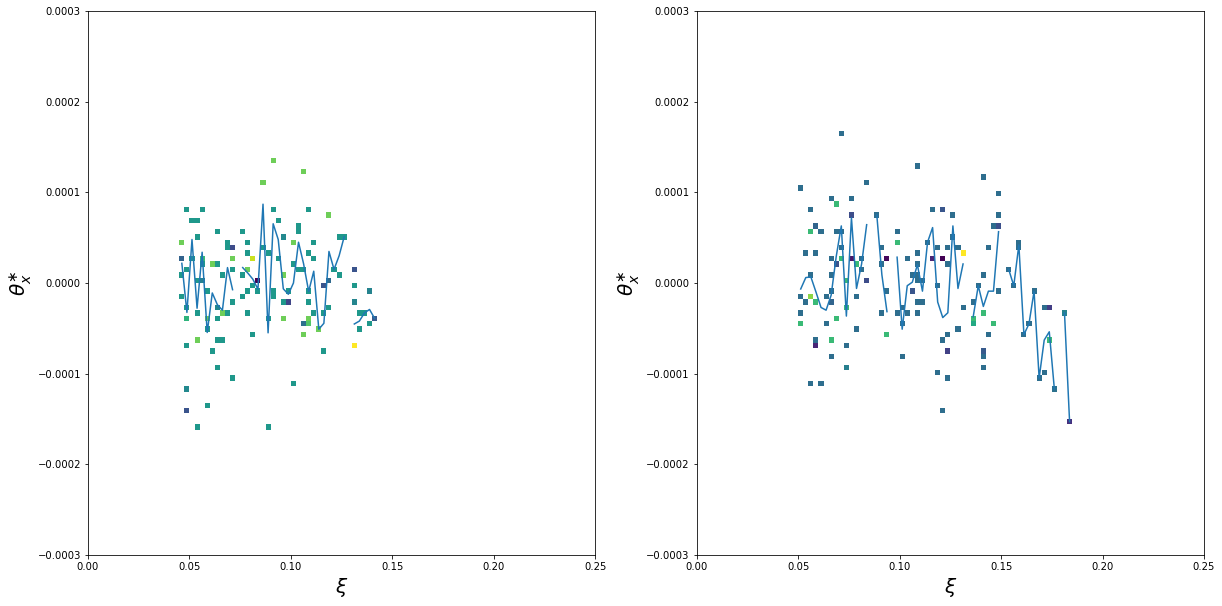

In [64]:
df_bkg = df_bkg_protons_xiMax
if proton_selection == "MultiRP":
    msk_bkg = ( df_bkg["InvMass"] >= 0. )
    # Multi-RP
    msk1_bkg = msk_bkg & ( df_bkg["MultiRP"] == 1 ) & ( df_bkg["Arm"] == 0 )
    msk2_bkg = msk_bkg & ( df_bkg["MultiRP"] == 1 ) & ( df_bkg["Arm"] == 1 )

    print ( len(df_bkg[ "Xi" ][ msk1_bkg ]), len(df_bkg[ "Xi" ][ msk2_bkg ]) )

    fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
    h_, xedges_, yedges_, im_ = axes[0].hist2d( df_bkg[ "Xi" ][ msk1_bkg ], df_bkg[ "ThX" ][ msk1_bkg ], bins=(100,100), range=( (0.,0.25), (-300.e-06,300.e-06) ), norm=LogNorm(), cmap='viridis' )
    bin_centres_x_ = ( xedges_[:-1] + xedges_[1:] ) / 2
    bin_centres_y_ = ( yedges_[:-1] + yedges_[1:] ) / 2
    axes[0].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )
    axes[0].set_xlabel( r"$\xi$", fontsize=20 )
    axes[0].set_ylabel( r"$\theta_x^{\ast}$", fontsize=20 )
    h_, xedges_, yedges_, im_ = axes[1].hist2d( df_bkg[ "Xi" ][ msk2_bkg], df_bkg[ "ThX" ][ msk2_bkg ], bins=(100,100), range=( (0.,0.25), (-300.e-06,300.e-06) ), norm=LogNorm(), cmap='viridis' )
    bin_centres_x_ = ( xedges_[:-1] + xedges_[1:] ) / 2
    bin_centres_y_ = ( yedges_[:-1] + yedges_[1:] ) / 2
    axes[1].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )
    axes[1].set_xlabel( r"$\xi$", fontsize=20 )
    axes[1].set_ylabel( r"$\theta_x^{\ast}$", fontsize=20 )

In [65]:
# fig = plt.figure( figsize=(12,10) )
# plt.hist( df_bkg["probability"], histtype='step', color='orange', bins=60, range=(0.,1.), weights=df_bkg["norm"] )
# plt.hist( df_signals['SingleDissociation']["probability"], histtype='step', color='darkblue', bins=60, range=(0.,1.), weights=( df_signals['SingleDissociation']["norm"] * df_signals['SingleDissociation']["eff_all_weighted"] ) )
# plt.hist( df_signals['Elastic']["probability"], histtype='step', color='skyblue', bins=60, range=(0.,1.), weights=( df_signals['Elastic']["norm"] * df_signals['Elastic']["eff_all_weighted"] ) )
# plt.yscale('log')

In [66]:
# fig = plt.figure( figsize=(12,10) )
# plt.hist(
#     [ df_bkg["probability"], df_signals['SingleDissociation']["probability"], df_signals['Elastic']["probability"] ],
#     color=[ 'orange', 'darkblue', 'skyblue' ],
#     weights=[ df_bkg["norm"], ( df_signals['SingleDissociation']["norm"] * df_signals['SingleDissociation']["eff_all_weighted"] ), ( df_signals['Elastic']["norm"] * df_signals['Elastic']["eff_all_weighted"] ) ],
#     stacked=True, bins=60, range=(0.,1.) )
# plt.yscale('log')

## Data

In [67]:
# label = "data"

# fileNames_data = [
#     'output/output-UL2017B-PreSel.h5',
#     'output/output-UL2017C1-PreSel.h5',
#     'output/output-UL2017E-PreSel_0.h5',
#     'output/output-UL2017E-PreSel_1.h5',
#     'output/output-UL2017F1-PreSel.h5'
# ]

# import time
# print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
# time_s_ = time.time()

# df_counts_data, df_data = 2 * [None]

# if run_tables:
#     with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), complevel=5 ) as store_:

#         df_counts_data_, df_data_ = get_data( fileNames_data )
#         df_data_ = process_data( df_data_, proton_selection=proton_selection, min_mass = 110., within_aperture=True )
        
#         store_[ "counts" ] = df_counts_data_
#         store_[ "df" ] = df_data_

# with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), 'r' ) as store_:
#     df_counts_data = store_[ "counts" ]
#     df_data = store_[ "df" ]
        
# time_e_ = time.time()
# print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

labels_data = [
    '2018A-PreSel-Pt1_30-Pt2_20',
    '2018B-PreSel-Pt1_30-Pt2_20'
]
labels_data = [
    '2018A-Excl-Pt1_30-Pt2_20',
    '2018B-Excl-Pt1_30-Pt2_20'
]

df_counts_data = {}
df_data_protons_multiRP_index = {}
df_data_protons_xiMax_multiRP = {}
df_data_protons_multiRP_events = {}

base_path_ = "output"
for label_ in labels_data:
    print ( label_ )
    file_path_ = "data-store-test-{}.h5".format( label_ )
    if base_path_ is not None and base_path_ != "": file_path_ = "{}/{}".format( base_path_, file_path_ )
        
    with pd.HDFStore( file_path_, 'r' ) as store_:
        print ( list( store_ ) )
        df_counts_data[ label_ ] = store_[ "counts" ]
        df_data_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_data_protons_xiMax_multiRP[ label_ ] = store_[ "protons_xiMax_multiRP" ]
        df_data_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]
        

2018A-Excl-Pt1_30-Pt2_20
['/counts', '/events_multiRP', '/protons_multiRP', '/protons_xiMax_multiRP']
2018B-Excl-Pt1_30-Pt2_20
['/counts', '/events_multiRP', '/protons_multiRP', '/protons_xiMax_multiRP']


In [68]:
df_data_protons_multiRP = pd.concat( df_data_protons_multiRP_index )
df_data_protons_multiRP

BX  \
                         Run    LumiSection EventNum  hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952 15618119849327436817 0       477.0   
                                                                           0       477.0   
                         316240 567         782960000 6065887369151992384  0      2934.0   
                         316060 396         400235712 7279231035136479856  0      3362.0   
                         315510 283         309580736 7007380532484353878  0      1111.0   
...                                                                                  ...   
2018B-Excl-Pt1_30-Pt2_20 317626 219         300424736 10554139707587351072 0      2204.0   
                                                                           0      2204.0   
                                                                           0      2204.0   
                                331         467028512 555164197449763875   0      1095.0   
                                                                           0      1095.0   

                                                                                  CrossingAngle  \
                         Run    LumiSection EventNum  hash_id              Slice                  
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952 15618119849327436817 0              150.0   
                                                                           0              150.0   
                         316240 567         782960000 6065887369151992384  0              133.0   
                         316060 396         400235712 7279231035136479856  0              130.0   
                         315510 283         309580736 7007380532484353878  0              149.0   
...                                                                                         ...   
2018B-Excl-Pt1_30-Pt2_20 317626 219         300424736 10554139707587351072 0              157.0   
                                                                           0              157.0   
                                                                           0              157.0   
                                331         467028512 555164197449763875   0              154.0   
                                                                           0              154.0   

                                                                                  random  \
                         Run    LumiSection EventNum  hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952 15618119849327436817 0           0   
                                                                           0           0   
                         316240 567         782960000 6065887369151992384  0           0   
                         316060 396         400235712 7279231035136479856  0           0   
                         315510 283         309580736 7007380532484353878  0           0   
...                                                                                  ...   
2018B-Excl-Pt1_30-Pt2_20 317626 219         300424736 10554139707587351072 0           0   
                                                                           0           0   
                                                                           0           0   
                                331         467028512 555164197449763875   0           0   
                                                                           0           0   

                                                                                  MultiRP  \
                         Run    LumiSection EventNum  hash_id              Slice            
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952 15618119849327436817 0            1   
                                                                           0            1   
                         316240 

In [69]:
df_data_protons_xiMax = pd.concat( df_data_protons_xiMax_multiRP )
df_data_protons_xiMax

BX  \
                         Run    LumiSection EventNum   hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0       477.0   
                         316240 567         782960000  6065887369151992384  0      2934.0   
                         316060 396         400235712  7279231035136479856  0      3362.0   
                         315510 283         309580736  7007380532484353878  0      1111.0   
                                                                            0      1111.0   
...                                                                                   ...   
2018B-Excl-Pt1_30-Pt2_20 317527 736         1017863104 2299808577464094111  0       108.0   
                                1345        1929113600 9958398652114750251  0      1016.0   
                         317626 219         300424736  10554139707587351072 0      2204.0   
                                                                            0      2204.0   
                                331         467028512  555164197449763875   0      1095.0   

                                                                                   CrossingAngle  \
                         Run    LumiSection EventNum   hash_id              Slice                  
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0              150.0   
                         316240 567         782960000  6065887369151992384  0              133.0   
                         316060 396         400235712  7279231035136479856  0              130.0   
                         315510 283         309580736  7007380532484353878  0              149.0   
                                                                            0              149.0   
...                                                                                          ...   
2018B-Excl-Pt1_30-Pt2_20 317527 736         1017863104 2299808577464094111  0              145.0   
                                1345        1929113600 9958398652114750251  0              137.0   
                         317626 219         300424736  10554139707587351072 0              157.0   
                                                                            0              157.0   
                                331         467028512  555164197449763875   0              154.0   

                                                                                   random  \
                         Run    LumiSection EventNum   hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0           0   
                         316240 567         782960000  6065887369151992384  0           0   
                         316060 396         400235712  7279231035136479856  0           0   
                         315510 283         309580736  7007380532484353878  0           0   
                                                                            0           0   
...                                                                                   ...   
2018B-Excl-Pt1_30-Pt2_20 317527 736         1017863104 2299808577464094111  0           0   
                                1345        1929113600 9958398652114750251  0           0   
                         317626 219         300424736  10554139707587351072 0           0   
                                                                            0           0   
                                331         467028512  555164197449763875   0           0   

                                                                                   MultiRP  \
                         Run    LumiSection EventNum   hash_id              Slice            
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0            1   
                         316240 567         782960000  6065887369151992384  0       

In [70]:
df_data_protons_xiMax = select_events( df_data_protons_xiMax )
df_data_protons_xiMax

BX  \
                         Run    LumiSection EventNum   hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0       477.0   
                         315510 283         309580736  7007380532484353878  0      1111.0   
                                                                            0      1111.0   
                         316702 324         474235872  5171439394148344683  0      2385.0   
                         316758 308         429492864  12416206528774177758 0       304.0   
...                                                                                   ...   
2018B-Excl-Pt1_30-Pt2_20 317527 569         752353152  23623380007381908    0      3026.0   
                                1345        1929113600 9958398652114750251  0      1016.0   
                         317626 219         300424736  10554139707587351072 0      2204.0   
                                                                            0      2204.0   
                                331         467028512  555164197449763875   0      1095.0   

                                                                                   CrossingAngle  \
                         Run    LumiSection EventNum   hash_id              Slice                  
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0              150.0   
                         315510 283         309580736  7007380532484353878  0              149.0   
                                                                            0              149.0   
                         316702 324         474235872  5171439394148344683  0              130.0   
                         316758 308         429492864  12416206528774177758 0              149.0   
...                                                                                          ...   
2018B-Excl-Pt1_30-Pt2_20 317527 569         752353152  23623380007381908    0              147.0   
                                1345        1929113600 9958398652114750251  0              137.0   
                         317626 219         300424736  10554139707587351072 0              157.0   
                                                                            0              157.0   
                                331         467028512  555164197449763875   0              154.0   

                                                                                   random  \
                         Run    LumiSection EventNum   hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0           0   
                         315510 283         309580736  7007380532484353878  0           0   
                                                                            0           0   
                         316702 324         474235872  5171439394148344683  0           0   
                         316758 308         429492864  12416206528774177758 0           0   
...                                                                                   ...   
2018B-Excl-Pt1_30-Pt2_20 317527 569         752353152  23623380007381908    0           0   
                                1345        1929113600 9958398652114750251  0           0   
                         317626 219         300424736  10554139707587351072 0           0   
                                                                            0           0   
                                331         467028512  555164197449763875   0           0   

                                                                                   MultiRP  \
                         Run    LumiSection EventNum   hash_id              Slice            
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0            1   
                         315510 283         309580736  7007380532484353878  0       

In [71]:
df_data_protons_xiMax[
    ['MultiRP', 'Arm', 'RPId1', 'RPId2',
     'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
     'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP',
     'Track1PixShift_MultiRP', 'Track2PixShift_MultiRP',
     'Xi', 'T', 'ThX', 'ThY', 'random'] ]

MultiRP  \
                         Run    LumiSection EventNum   hash_id              Slice            
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0            1   
                         315510 283         309580736  7007380532484353878  0            1   
                                                                            0            1   
                         316702 324         474235872  5171439394148344683  0            1   
                         316758 308         429492864  12416206528774177758 0            1   
...                                                                                    ...   
2018B-Excl-Pt1_30-Pt2_20 317527 569         752353152  23623380007381908    0            1   
                                1345        1929113600 9958398652114750251  0            1   
                         317626 219         300424736  10554139707587351072 0            1   
                                                                            0            1   
                                331         467028512  555164197449763875   0            1   

                                                                                   Arm  \
                         Run    LumiSection EventNum   hash_id              Slice        
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0        0   
                         315510 283         309580736  7007380532484353878  0        0   
                                                                            0        1   
                         316702 324         474235872  5171439394148344683  0        0   
                         316758 308         429492864  12416206528774177758 0        1   
...                                                                                ...   
2018B-Excl-Pt1_30-Pt2_20 317527 569         752353152  23623380007381908    0        1   
                                1345        1929113600 9958398652114750251  0        0   
                         317626 219         300424736  10554139707587351072 0        0   
                                                                            0        1   
                                331         467028512  555164197449763875   0        0   

                                                                                   RPId1  \
                         Run    LumiSection EventNum   hash_id              Slice          
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0          3   
                         315510 283         309580736  7007380532484353878  0          3   
                                                                            0        103   
                         316702 324         474235872  5171439394148344683  0          3   
                         316758 308         429492864  12416206528774177758 0        103   
...                                                                                  ...   
2018B-Excl-Pt1_30-Pt2_20 317527 569         752353152  23623380007381908    0        103   
                                1345        1929113600 9958398652114750251  0          3   
                         317626 219         300424736  10554139707587351072 0          3   
                                                                            0        103   
                                331         467028512  555164197449763875   0          3   

                                                                                   RPId2  \
                         Run    LumiSection EventNum   hash_id              Slice          
2018A-Excl-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0         23   
                         315510 283         309580736  7007380532484353878  0         23   
                                                                            0        123   
                         316702 

In [72]:
# #df_data["period"] = df_data.apply( f_data_period_, axis=1 )
# #df_data["period"] = df_data["Run"].map( f_data_period_ )
# df_data.loc[ :, "period" ] = np.nan
# for idx_ in range( df_run_ranges.shape[0] ):
#     msk_period_ = ( ( df_data[ "Run" ] >= df_run_ranges.iloc[ idx_ ][ "min" ] ) & ( df_data[ "Run" ] <= df_run_ranges.iloc[ idx_ ][ "max" ] ) )
#     sum_period_ = np.sum( msk_period_ )
#     if sum_period_ > 0:
#         period_key_ = df_run_ranges.index[ idx_ ]
#         df_data.loc[ :, "period" ].loc[ msk_period_ ] = period_key_
#         print ( "{}: {}".format( period_key_, sum_period_ ) )

In [73]:
# if proton_selection == "MultiRP":
#     #df_data[ "within_aperture" ] = df_data.apply( lambda row: check_aperture( aperture_period_map[ row["period"][0] ], row["Arm"], row["CrossingAngle"], row["Xi"], row["ThX"] ), axis=1 )
#     df_data[ "within_aperture" ] = df_data.apply( lambda row: check_aperture( aperture_period_map[ row["period"][0] ], row["Arm"], row["CrossingAngle"], row["Xi"], row["ThX"] ), axis=1 )

In [74]:
#df_data[ ["Xi", "ThX", "period", "within_aperture" ] ]

In [75]:
# df_data = df_data[ df_data[ "within_aperture" ] ]
# df_data

131 152


/tmp/ipykernel_633/2387219076.py:14: RuntimeWarning: invalid value encountered in divide
  axes[0].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )
/tmp/ipykernel_633/2387219076.py:20: RuntimeWarning: invalid value encountered in divide
  axes[1].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )


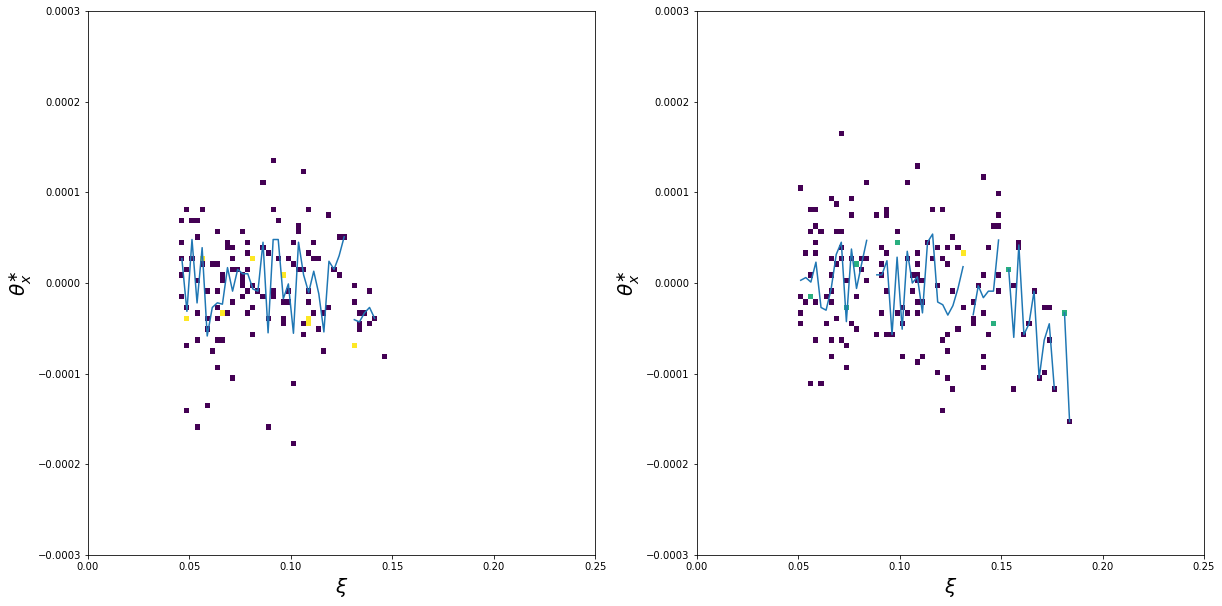

In [76]:
df_data = df_data_protons_xiMax
if proton_selection == "MultiRP":
    msk_data = ( df_data["InvMass"] >= 0. )
    # Multi-RP
    msk1_data = msk_data & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk2_data = msk_data & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )

    print ( len(df_data[ "Xi" ][ msk1_data ]), len(df_data[ "Xi" ][ msk2_data ]) )

    fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
    h_, xedges_, yedges_, im_ = axes[0].hist2d( df_data[ "Xi" ][ msk1_data ], df_data[ "ThX" ][ msk1_data ], bins=(100,100), range=( (0.,0.25), (-300.e-06,300.e-06) ), norm=LogNorm(), cmap='viridis' )
    bin_centres_x_ = ( xedges_[:-1] + xedges_[1:] ) / 2
    bin_centres_y_ = ( yedges_[:-1] + yedges_[1:] ) / 2
    axes[0].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )
    axes[0].set_xlabel( r"$\xi$", fontsize=20 )
    axes[0].set_ylabel( r"$\theta_x^{\ast}$", fontsize=20 )
    h_, xedges_, yedges_, im_ = axes[1].hist2d( df_data[ "Xi" ][ msk2_data ], df_data[ "ThX" ][ msk2_data ], bins=(100,100), range=( (0.,0.25), (-300.e-06,300.e-06) ), norm=LogNorm(), cmap='viridis' )
    bin_centres_x_ = ( xedges_[:-1] + xedges_[1:] ) / 2
    bin_centres_y_ = ( yedges_[:-1] + yedges_[1:] ) / 2
    axes[1].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )
    axes[1].set_xlabel( r"$\xi$", fontsize=20 )
    axes[1].set_ylabel( r"$\theta_x^{\ast}$", fontsize=20 )

### Plot data vs MC

In [77]:
df_signal_protons = df_signal_plus_mix_protons_xiMax_multiRP_sig_protons
df_mixed_protons = df_signal_plus_mix_protons_xiMax_multiRP_mixed_protons

for label_ in df_signals_protons_multiRP_index:
    df_signal_protons[ label_ ][ "xi_ratio" ] = ( 1. - df_signal_protons[ label_ ][ "Xi" ] / df_signal_protons[ label_ ][ "XiMuMu" ] )
    df_mixed_protons[ label_ ][ "xi_ratio" ] = ( 1. - df_mixed_protons[ label_ ][ "Xi" ] / df_mixed_protons[ label_ ][ "XiMuMu" ] )
    
df_bkg[ "xi_ratio" ] = ( 1. - df_bkg[ "Xi" ] / df_bkg[ "XiMuMu" ] )
df_data[ "xi_ratio" ] = ( 1. - df_data[ "Xi" ] / df_data[ "XiMuMu" ] )

In [78]:
# def plot_data_mc( var, hist_bins, hist_range, df_data, df_mc_list, weights_mc_list, labels_mc, fig=None, ax=None ):
#     if fig is None: fig = plt.figure( figsize=(12,10) )
#     color=[ 'orange', 'darkblue', 'skyblue', 'lightblue' ]
#     mc_data_var = [ df[ var ] for df in df_mc_list ]
#     color = color[:len(mc_data_var)]
    
#     ax_ = plt.gca() if ax is None else ax 
#     ax_.hist(
#         mc_data_var,
#         color=color,
#         weights=weights_mc_list, label=labels_mc,
#         stacked=True, bins=hist_bins, range=hist_range )

#     counts, bin_edges = np.histogram( df_data[ var ], bins=hist_bins, range=hist_range )
#     errors = np.sqrt( counts )
#     bin_centres = ( bin_edges[:-1] + bin_edges[1:] ) / 2.
#     ax_.errorbar(bin_centres, counts, yerr=errors, fmt='o', label='Data')
    
#     return ( fig, ax_ )

In [79]:
def calculate_mixed_bkg( var, hist_bins, hist_range,
                         df_bkg, df_mixed_list,
                         weights_bkg, weights_mixed_list ):
    
    sumw_bkg_, bins_ = np.histogram( df_bkg[ var ], weights=weights_bkg, bins=hist_bins, range=hist_range )
    sumw2_bkg_ = ( sumw_bkg_ ** 2 )

    label_mixed_ = ""
    sumw_mixed_ = None
    sumw2_mixed_ = None
    for idx_ in range( len( df_mixed_list ) ):
        sumw_mixed__, bins__ = np.histogram( df_mixed_list[ idx_ ][ var ], weights=weights_mixed_list[ idx_ ], bins=hist_bins, range=hist_range )
        if sumw_mixed_ is None:
            sumw_mixed_ = sumw_mixed__
            sumw2_mixed_ = ( sumw_mixed__ ** 2 )
        else:
            sumw_mixed_ += sumw_mixed__
            sumw2_mixed_ += ( sumw_mixed__ ** 2 )
        if idx_ == 0:
            label_mixed_ = labels_mc[ idx_ ]
        else:
            label_mixed_ += " + " + labels_mc[ idx_ ]
    label_mixed_ += " (pileup proton)"
    
    sumw_bkg_sub_ = ( sumw_bkg_ - sumw_mixed_ )
    sumw2_bkg_sub_ = ( sumw2_bkg_ + sumw2_mixed_ )
    print ( sumw_bkg_sub_ )
    print ( sumw2_bkg_sub_ )
    vals_bins_ = ( bins_[:-1] + bins_[1:] ) / 2

    return ( vals_bins_, sumw_bkg_sub_, sumw2_bkg_sub_, sumw_mixed_, sumw2_mixed_ )

def plot_data_mc( hist_bins, hist_range,
                  vals_data, vals_bkg, vals_mixed, vals_sig_list,
                  weights_bkg, weights_mixed, weights_sig_list, label_bkg, label_mixed, labels_mc, colors, fig=None, ax=None ):
    
    if fig is None: fig = plt.figure( figsize=(12,10) )

    # df_sig_tot_list = []
    # weights_sig_tot_list = []
    # for idx_ in range( len( df_sig_list ) ):
    #     df_sig_tot_list.append( pd.concat( [ df_sig_list[ idx_ ], df_mixed_list[ idx_ ] ] ) )
    #     weights_sig_tot_list.append( pd.concat( [ weights_sig_list[ idx_ ], weights_mixed_list[ idx_ ] ] ) )
    
    labels_ = [ label_bkg ]
    data_var_list_ = [ vals_bkg ]
    weights_var_list_ = [ weights_bkg ]
    
    labels_.append( label_mixed )
    data_var_list_.append( vals_mixed )
    weights_var_list_.append( weights_mixed )
    
    # data_var_list_.extend( [ df__[ var ] for df__ in df_sig_list ] )
    # weights_var_list_.extend( weights_sig_list )
    # labels_.extend( [ key_ + "(mixed)" for key_ in labels_mc ] )
    # data_var_list_.extend( [ df__[ var ] for df__ in df_mixed_list ] )
    # weights_var_list_.extend( weights_mixed_list )
    
    labels_.extend( labels_mc )
    # data_var_list_.extend( [ df__[ var ] for df__ in df_sig_tot_list ] )
    # weights_var_list_.extend( weights_sig_tot_list )
    # data_var_list_.extend( [ df__[ var ] for df__ in df_sig_list ] )
    data_var_list_.extend( vals_sig_list )
    weights_var_list_.extend( weights_sig_list )
    colors_ = colors[:len(data_var_list_)]
    print ( data_var_list_ )
    print ( weights_var_list_ )
    print ( labels_ )
    
    ax_ = plt.gca() if ax is None else ax
    ax_.hist(
        data_var_list_,
        weights=weights_var_list_, label=labels_,
        color=colors_,
        stacked=True, bins=hist_bins, range=hist_range )

    # counts, bin_edges = np.histogram( df_data[ var ], bins=hist_bins, range=hist_range )
    counts, bin_edges = np.histogram( vals_data, bins=hist_bins, range=hist_range )
    errors = np.sqrt( counts )
    bin_centres = ( bin_edges[:-1] + bin_edges[1:] ) / 2.
    ax_.errorbar(bin_centres, counts, yerr=errors, fmt='o', label='Data')

    ax_.legend( loc='best' )
    
    return ( fig, ax_ )

In [80]:
msk1_data = None
msk2_data = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk1_data = ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 23 )
    msk2_data = ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk1_data = ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk2_data = ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )

df_data_1 = df_data[ msk1_data ]
df_data_2 = df_data[ msk2_data ]

# df_mc_list      = [ df_bkg, df_signals['SingleDissociation'], df_signals['Elastic'] ]
# weights_mc_list = [ df_bkg["norm"], df_signals['SingleDissociation']["norm"], df_signals['Elastic']["norm"] ]
# weights_mc_list = [ df_bkg["norm"], ( df_signals['SingleDissociation']["norm"] * df_signals['SingleDissociation']["eff_all_weighted"] ), ( df_signals['Elastic']["norm"] * df_signals['Elastic']["eff_all_weighted"] ) ]_list = [ df_bkg["norm"], ( df_signals['SingleDissociation']["norm"] * df_signals['SingleDissociation']["eff_all_weighted"] ), ( df_signals['Elastic']["norm"] * df_signals['Elastic']["eff_all_weighted"] ) ]
df_sig_list = [
    df_signal_protons[ 'GGToMuMu_Pt-25_Inel-Inel' ],
    df_signal_protons[ 'GGToMuMu_Pt-25_Inel-El' ],
    df_signal_protons[ 'GGToMuMu_Pt-25_Elastic' ]
    ]
df_mixed_list = [
    df_mixed_protons[ 'GGToMuMu_Pt-25_Inel-Inel' ],
    df_mixed_protons[ 'GGToMuMu_Pt-25_Inel-El' ],
    df_mixed_protons[ 'GGToMuMu_Pt-25_Elastic' ]
    ]

weights_bkg = df_bkg["norm"]
weights_sig_list = [
    ( df_signal_protons[ 'GGToMuMu_Pt-25_Inel-Inel' ]["norm"] * df_signal_protons[ 'GGToMuMu_Pt-25_Inel-Inel' ]["eff_proton_all"] ),
    ( df_signal_protons[ 'GGToMuMu_Pt-25_Inel-El' ]["norm"] * df_signal_protons[ 'GGToMuMu_Pt-25_Inel-El' ]["eff_proton_all"] ),
    ( df_signal_protons[ 'GGToMuMu_Pt-25_Elastic' ]["norm"] * df_signal_protons[ 'GGToMuMu_Pt-25_Elastic' ]["eff_proton_all"] )
    ]
weights_mixed_list = [
    ( df_mixed_protons[ 'GGToMuMu_Pt-25_Inel-Inel' ]["norm"] ),
    ( df_mixed_protons[ 'GGToMuMu_Pt-25_Inel-El' ]["norm"] ),
    ( df_mixed_protons[ 'GGToMuMu_Pt-25_Elastic' ]["norm"] )
    ]
labels_mc = [ "Double-dissociative", "Single-dissociative", "Elastic" ]

df_bkg_1 = None
df_bkg_2 = None
df_sig_list_1 = []
df_sig_list_2 = []
df_mixed_list_1 = []
df_mixed_list_2 = []

weights_bkg_1 = None
weights_bkg_2 = None
weights_sig_list_1 = []
weights_sig_list_2 = []
weights_mixed_list_1 = []
weights_mixed_list_2 = []

df_ = df_bkg
msk1_ = None
msk2_ = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk1_ = ( df_["MultiRP"] == 0) & ( df_["RPId1"] == 23 )
    msk2_ = ( df_["MultiRP"] == 0) & ( df_["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk1_ = ( df_["MultiRP"] == 1 ) & ( df_["Arm"] == 0 )
    msk2_ = ( df_["MultiRP"] == 1 ) & ( df_["Arm"] == 1 )
df_bkg_1 = df_[ msk1_ ]
df_bkg_2 = df_[ msk2_ ]
weights_bkg_1 = weights_bkg[ msk1_ ]
weights_bkg_2 = weights_bkg[ msk2_ ]

for idx_ in range( len( df_sig_list ) ):
    df_ = df_sig_list[idx_]    
    msk1_ = None
    msk2_ = None
    if proton_selection == "SingleRP":
        # Single-RP in pixel stations
        msk1_ = ( df_["MultiRP"] == 0) & ( df_["RPId1"] == 23 )
        msk2_ = ( df_["MultiRP"] == 0) & ( df_["RPId1"] == 123 )
    elif proton_selection == "MultiRP":
        # Multi-RP
        msk1_ = ( df_["MultiRP"] == 1 ) & ( df_["Arm"] == 0 )
        msk2_ = ( df_["MultiRP"] == 1 ) & ( df_["Arm"] == 1 )
        
    df_sig_list_1.append( df_[ msk1_ ] )
    df_sig_list_2.append( df_[ msk2_ ] )
    weights_sig_list_1.append( weights_sig_list[idx_][ msk1_ ] )
    weights_sig_list_2.append( weights_sig_list[idx_][ msk2_ ] )

for idx_ in range( len( df_mixed_list ) ):
    df_ = df_mixed_list[idx_]    
    msk1_ = None
    msk2_ = None
    if proton_selection == "SingleRP":
        # Single-RP in pixel stations
        msk1_ = ( df_["MultiRP"] == 0) & ( df_["RPId1"] == 23 )
        msk2_ = ( df_["MultiRP"] == 0) & ( df_["RPId1"] == 123 )
    elif proton_selection == "MultiRP":
        # Multi-RP
        msk1_ = ( df_["MultiRP"] == 1 ) & ( df_["Arm"] == 0 )
        msk2_ = ( df_["MultiRP"] == 1 ) & ( df_["Arm"] == 1 )
        
    df_mixed_list_1.append( df_[ msk1_ ] )
    df_mixed_list_2.append( df_[ msk2_ ] )
    weights_mixed_list_1.append( weights_mixed_list[idx_][ msk1_ ] )
    weights_mixed_list_2.append( weights_mixed_list[idx_][ msk2_ ] )
    

[ 2.43768271 -0.32440341 -0.77958399  3.03609659  5.54480776  5.78043386
 11.58391194  0.55109928]
[ 43.38579429  24.96603399  32.78653377 107.94443718 197.36928129
 259.50557755 305.05829833   3.7700746 ]
[-4.625 -3.875 -3.125 -2.375 -1.625 -0.875 -0.125  0.625] [ 2.43768271 -0.32440341 -0.77958399  3.03609659  5.54480776  5.78043386
 11.58391194  0.55109928] [ 43.38579429  24.96603399  32.78653377 107.94443718 197.36928129
 259.50557755 305.05829833   3.7700746 ] [3.62231729 4.30440341 5.19958399 6.34390341 7.47519224 9.03956614
 5.47608806 1.20890072] [ 6.66219429  9.12563399 13.25013377 19.96003718 27.84888129 39.87317755
 14.01469833  0.6724746 ]
[-1.117375    4.19245323  1.54382979  7.31570933 -1.51996567 -2.74693526
  9.3533076   1.04858829]
[ 17.63211529  94.91299471  61.42583019 226.75565804  76.31605166
  60.68742466 205.53687103   4.4127234 ]
[-4.625 -3.875 -3.125 -2.375 -1.625 -0.875 -0.125  0.625] [-1.117375    4.19245323  1.54382979  7.31570933 -1.51996567 -2.74693526
  9

(0.0, 32.076696830622026)

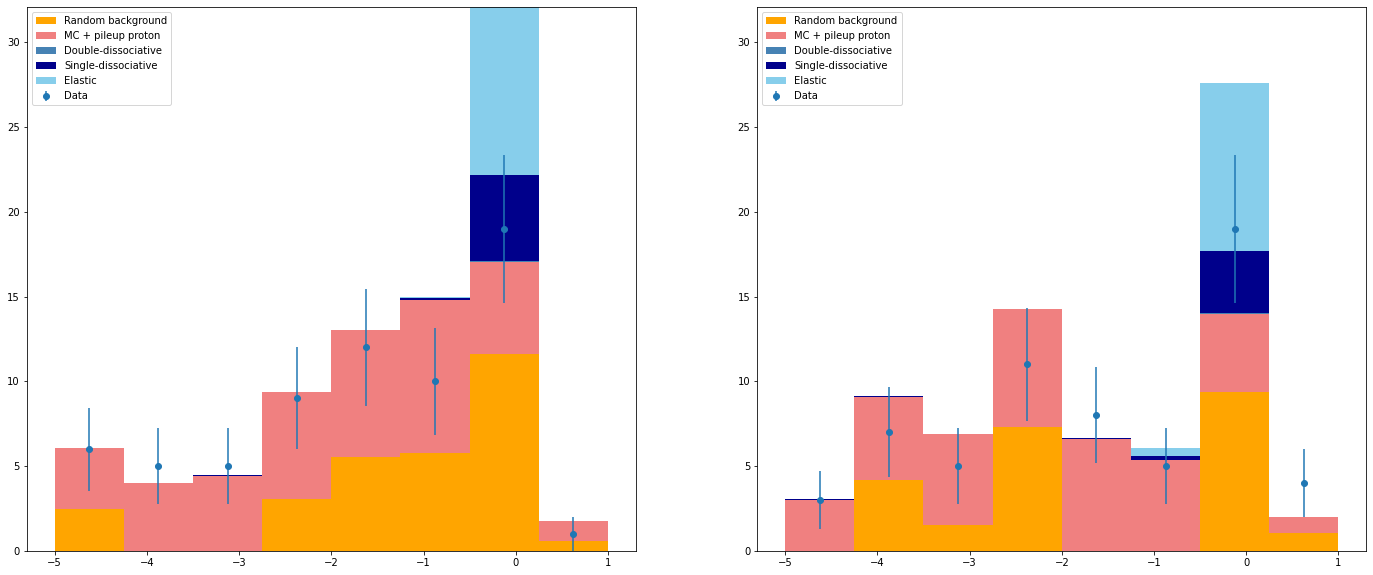

In [81]:
fig, axes = plt.subplots( 1, 2, figsize=(24,10) )

var_ = "xi_ratio"
hist_bins_ = 8
hist_range_ = (-5.,1.)

vals_bins_1, sumw_bkg_sub_1, sumw2_bkg_sub_1, sumw_mixed_1, sumw2_mixed_1 = calculate_mixed_bkg(
    var_, hist_bins_, hist_range_,
    df_bkg_1, df_mixed_list_1,
    weights_bkg_1, weights_mixed_list_1 )
print ( vals_bins_1, sumw_bkg_sub_1, sumw2_bkg_sub_1, sumw_mixed_1, sumw2_mixed_1 )
vals_bins_2, sumw_bkg_sub_2, sumw2_bkg_sub_2, sumw_mixed_2, sumw2_mixed_2 = calculate_mixed_bkg(
    var_, hist_bins_, hist_range_,
    df_bkg_2, df_mixed_list_2,
    weights_bkg_2, weights_mixed_list_2 )
print ( vals_bins_2, sumw_bkg_sub_2, sumw2_bkg_sub_2, sumw_mixed_2, sumw2_mixed_2 )

counts_1, _ = np.histogram( df_data_1[ var_ ], bins=hist_bins_, range=hist_range_ )
counts_2, _ = np.histogram( df_data_2[ var_ ], bins=hist_bins_, range=hist_range_ )
errors_1 = np.sqrt( counts_1 )
errors_2 = np.sqrt( counts_2 )
idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_]
y_max += np.max( [ 3*np.concatenate( [errors_1, errors_2] )[idx_ymax_], 0.30*y_max ] )

# fig_, ax_ = plot_data_mc( var_, hist_bins=hist_bins_, hist_range=hist_range_,
#                           df_data=df_data_1,
#                           df_bkg=df_bkg_1,
#                           df_sig_list=df_sig_list_1,
#                           df_mixed_list=df_mixed_list_1,
#                           weights_bkg=weights_bkg_1,
#                           weights_sig_list=weights_sig_list_1,
#                           weights_mixed_list=weights_mixed_list_1,
#                           labels_mc=labels_mc,
#                           fig=fig, ax=axes[0]
#                           )
# fig_, ax_ = plot_data_mc( var_, hist_bins=hist_bins_, hist_range=hist_range_,
#                           df_data=df_data_2,
#                           df_bkg=df_bkg_2,
#                           df_sig_list=df_sig_list_2,
#                           df_mixed_list=df_mixed_list_2,
#                           weights_bkg=weights_bkg_2,
#                           weights_sig_list=weights_sig_list_2,
#                           weights_mixed_list=weights_mixed_list_2,
#                           labels_mc=labels_mc,
#                           fig=fig, ax=axes[1]
#                           )

fig_, ax_ = plot_data_mc( hist_bins=hist_bins_, hist_range=hist_range_,
                          vals_data=df_data_1[ var_ ],
                          vals_bkg=vals_bins_1,
                          vals_mixed=vals_bins_1,
                          vals_sig_list=[ df__[ var_ ] for df__ in df_sig_list_1 ],
                          weights_bkg=sumw_bkg_sub_1,
                          weights_mixed=sumw_mixed_1, 
                          weights_sig_list=weights_sig_list_1,
                          label_bkg="Random background",
                          label_mixed="MC + pileup proton",
                          labels_mc=labels_mc,
                          colors=[ 'orange', 'lightcoral', 'steelblue', 'darkblue', 'skyblue' ],
                          fig=fig, ax=axes[0]
                          )
fig_, ax_ = plot_data_mc( hist_bins=hist_bins_, hist_range=hist_range_,
                          vals_data=df_data_2[ var_ ],
                          vals_bkg=vals_bins_2,
                          vals_mixed=vals_bins_2,
                          vals_sig_list=[ df__[ var_ ] for df__ in df_sig_list_2 ],
                          weights_bkg=sumw_bkg_sub_2,
                          weights_mixed=sumw_mixed_2, 
                          weights_sig_list=weights_sig_list_2,
                          label_bkg="Random background",
                          label_mixed="MC + pileup proton",
                          labels_mc=labels_mc,
                          colors=[ 'orange', 'lightcoral', 'steelblue', 'darkblue', 'skyblue' ],
                          fig=fig, ax=axes[1]
                          )
axes[0].set_ylim( bottom=0., top=y_max )
axes[1].set_ylim( bottom=0., top=y_max )
# axes[0].set_yscale('log')
# axes[1].set_yscale('log')

### Signal region

In [82]:
xi_ratio_min_ = -0.50
xi_ratio_max_ = +0.30

msk1_ = ( df_data_1[ "xi_ratio" ] >= xi_ratio_min_ ) & ( df_data_1[ "xi_ratio" ] <= xi_ratio_max_ )
msk2_ = ( df_data_2[ "xi_ratio" ] >= xi_ratio_min_ ) & ( df_data_2[ "xi_ratio" ] <= xi_ratio_max_ )
df_data_sel_1 = df_data_1[ msk1_ ]
df_data_sel_2 = df_data_2[ msk2_ ]

msk1_ = ( df_bkg_1[ "xi_ratio" ] >= xi_ratio_min_ ) & ( df_bkg_1[ "xi_ratio" ] <= xi_ratio_max_ )
msk2_ = ( df_bkg_2[ "xi_ratio" ] >= xi_ratio_min_ ) & ( df_bkg_2[ "xi_ratio" ] <= xi_ratio_max_ )
df_bkg_sel_1 = df_bkg_1[ msk1_ ]
df_bkg_sel_2 = df_bkg_2[ msk2_ ]
weights_bkg_sel_1 = weights_bkg_1[ msk1_ ]
weights_bkg_sel_2 = weights_bkg_2[ msk2_ ]

df_sig_list_sel_1 = []
df_sig_list_sel_2 = []
weights_sig_list_sel_1 = []
weights_sig_list_sel_2 = []
df_mixed_list_sel_1 = []
df_mixed_list_sel_2 = []
weights_mixed_list_sel_1 = []
weights_mixed_list_sel_2 = []
for idx_ in range( len( df_sig_list ) ):
    msk1_ = ( df_sig_list_1[idx_][ "xi_ratio" ] >= xi_ratio_min_ ) & ( df_sig_list_1[idx_][ "xi_ratio" ] <= xi_ratio_max_ )
    msk2_ = ( df_sig_list_2[idx_][ "xi_ratio" ] >= xi_ratio_min_ ) & ( df_sig_list_2[idx_][ "xi_ratio" ] <= xi_ratio_max_ )
    df_sig_list_sel_1.append( df_sig_list_1[idx_][ msk1_ ] )
    df_sig_list_sel_2.append( df_sig_list_2[idx_][ msk2_ ] )
    weights_sig_list_sel_1.append( weights_sig_list_1[idx_][ msk1_ ] )
    weights_sig_list_sel_2.append( weights_sig_list_2[idx_][ msk2_ ] )
    
    msk1_ = ( df_mixed_list_1[idx_][ "xi_ratio" ] >= xi_ratio_min_ ) & ( df_mixed_list_1[idx_][ "xi_ratio" ] <= xi_ratio_max_ )
    msk2_ = ( df_mixed_list_2[idx_][ "xi_ratio" ] >= xi_ratio_min_ ) & ( df_mixed_list_2[idx_][ "xi_ratio" ] <= xi_ratio_max_ )
    df_mixed_list_sel_1.append( df_mixed_list_1[idx_][ msk1_ ] )
    df_mixed_list_sel_2.append( df_mixed_list_2[idx_][ msk2_ ] )
    weights_mixed_list_sel_1.append( weights_mixed_list_1[idx_][ msk1_ ] )
    weights_mixed_list_sel_2.append( weights_mixed_list_2[idx_][ msk2_ ] )
    

[6.71115502 2.1919363  0.88304297 0.60990505 2.07106465]
[88.02725606 13.04385712  3.04012331  1.06903874  5.41127912]
[149. 227. 305. 383. 461.] [6.71115502 2.1919363  0.88304297 0.60990505 2.07106465] [88.02725606 13.04385712  3.04012331  1.06903874  5.41127912] [2.50884498 1.3080637  0.77695703 0.39009495 0.24893535] [3.01885606 0.79385712 0.28452331 0.06903874 0.02887912]
[6.20883066 3.21789834 0.58370804 0.06076087 0.62174313]
[66.23833263 19.4322173   2.07332926  0.2350728   0.7268263 ]
[149. 227. 305. 383. 461.] [6.20883066 3.21789834 0.58370804 0.06076087 0.62174313] [66.23833263 19.4322173   2.07332926  0.2350728   0.7268263 ] [1.83116934 1.12210166 0.75629196 0.35923913 0.21825687] [1.59673263 0.5966173  0.27772926 0.0586728  0.0212263 ]
[array([149., 227., 305., 383., 461.], dtype=float32), array([149., 227., 305., 383., 461.], dtype=float32), Run  LumiSection  EventNum  hash_id               Slice
1    3            2145      7951376066954384577   0        178.172531
     5 

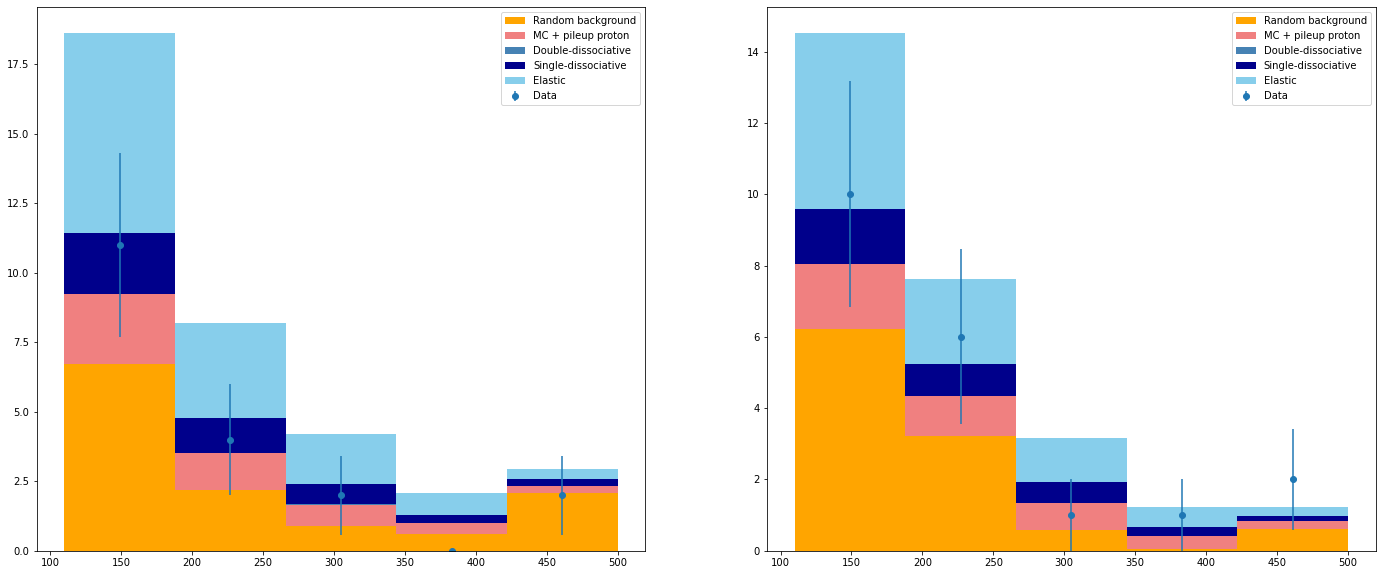

In [83]:
fig, axes = plt.subplots( 1, 2, figsize=(24,10) )

# var_ = "xi_ratio"
# hist_bins_ = 8
# hist_range_ = (-1.,1.)

# var_ = "Xi"
# hist_bins_ = 10
# hist_range_ = (0.05,0.15)

# var_ = "ThX"
# hist_bins_ = 10
# hist_range_ = (-0.0005,0.0005)

# var_ = "ThY"
# hist_bins_ = 10
# hist_range_ = (-0.0005,0.0005)

var_ = "InvMass"
hist_bins_ = 5
hist_range_ = (110.,500.)

# fig_, ax_ = plot_data_mc( var_, hist_bins=hist_bins_, hist_range=hist_range_,
#                           df_data=df_data_sel_1,
#                           df_bkg=df_bkg_sel_1,
#                           df_sig_list=df_sig_list_sel_1,
#                           df_mixed_list=df_mixed_list_sel_1,
#                           weights_bkg=weights_bkg_sel_1,
#                           weights_sig_list=weights_sig_list_sel_1,
#                           weights_mixed_list=weights_mixed_list_sel_1,
#                           labels_mc=labels_mc,
#                           fig=fig, ax=axes[0]
#                           )
# fig_, ax_ = plot_data_mc( var_, hist_bins=hist_bins_, hist_range=hist_range_,
#                           df_data=df_data_sel_2,
#                           df_bkg=df_bkg_sel_2,
#                           df_sig_list=df_sig_list_sel_2,
#                           df_mixed_list=df_mixed_list_sel_2,
#                           weights_bkg=weights_bkg_sel_2,
#                           weights_sig_list=weights_sig_list_sel_2,
#                           weights_mixed_list=weights_mixed_list_sel_2,
#                           labels_mc=labels_mc,
#                           fig=fig, ax=axes[1]
#                           )

vals_bins_1, sumw_bkg_sub_1, sumw2_bkg_sub_1, sumw_mixed_1, sumw2_mixed_1 = calculate_mixed_bkg(
    var_, hist_bins_, hist_range_,
    df_bkg_sel_1, df_mixed_list_sel_1,
    weights_bkg_sel_1, weights_mixed_list_sel_1 )
print ( vals_bins_1, sumw_bkg_sub_1, sumw2_bkg_sub_1, sumw_mixed_1, sumw2_mixed_1 )
vals_bins_2, sumw_bkg_sub_2, sumw2_bkg_sub_2, sumw_mixed_2, sumw2_mixed_2 = calculate_mixed_bkg(
    var_, hist_bins_, hist_range_,
    df_bkg_sel_2, df_mixed_list_sel_2,
    weights_bkg_sel_2, weights_mixed_list_sel_2 )
print ( vals_bins_2, sumw_bkg_sub_2, sumw2_bkg_sub_2, sumw_mixed_2, sumw2_mixed_2 )

fig_, ax_ = plot_data_mc( hist_bins=hist_bins_, hist_range=hist_range_,
                          vals_data=df_data_sel_1[ var_ ],
                          vals_bkg=vals_bins_1,
                          vals_mixed=vals_bins_1,
                          vals_sig_list=[ df__[ var_ ] for df__ in df_sig_list_sel_1 ],
                          weights_bkg=sumw_bkg_sub_1,
                          weights_mixed=sumw_mixed_1, 
                          weights_sig_list=weights_sig_list_sel_1,
                          label_bkg="Random background",
                          label_mixed="MC + pileup proton",
                          labels_mc=labels_mc,
                          colors=[ 'orange', 'lightcoral', 'steelblue', 'darkblue', 'skyblue' ],
                          fig=fig, ax=axes[0]
                          )
fig_, ax_ = plot_data_mc( hist_bins=hist_bins_, hist_range=hist_range_,
                          vals_data=df_data_sel_2[ var_ ],
                          vals_bkg=vals_bins_2,
                          vals_mixed=vals_bins_2,
                          vals_sig_list=[ df__[ var_ ] for df__ in df_sig_list_sel_2 ],
                          weights_bkg=sumw_bkg_sub_2,
                          weights_mixed=sumw_mixed_2, 
                          weights_sig_list=weights_sig_list_sel_2,
                          label_bkg="Random background",
                          label_mixed="MC + pileup proton",
                          labels_mc=labels_mc,
                          colors=[ 'orange', 'lightcoral', 'steelblue', 'darkblue', 'skyblue' ],
                          fig=fig, ax=axes[1]
                          )

### Only Elastic

[7.87807485 2.87967611 1.33506844 0.85230384 2.21872263]
[86.80916311 12.63480173  2.86118052  1.02181416  5.39265711]
[7.87807485 2.87967611 1.33506844 0.85230384 2.21872263] [86.80916311 12.63480173  2.86118052  1.02181416  5.39265711] [1.34192515 0.62032389 0.32493156 0.14769616 0.10127737] [1.80076311 0.38480173 0.10558052 0.02181416 0.01025711]
[7.06098543 3.75765512 1.00662866 0.23854471 0.74294252]
[65.60006954 19.17472555  1.90673645  0.20932602  0.71502015]
[7.06098543 3.75765512 1.00662866 0.23854471 0.74294252] [65.60006954 19.17472555  1.90673645  0.20932602  0.71502015] [0.97901457 0.58234488 0.33337134 0.18145529 0.09705748] [0.95846954 0.33912555 0.11113645 0.03292602 0.00942015]
[array([149., 227., 305., 383., 461.], dtype=float32), array([149., 227., 305., 383., 461.], dtype=float32), Run  LumiSection  EventNum  hash_id               Slice
1    5            457       10562876369888048678  0         330.360657
                  492       2990890362874645505   0        1

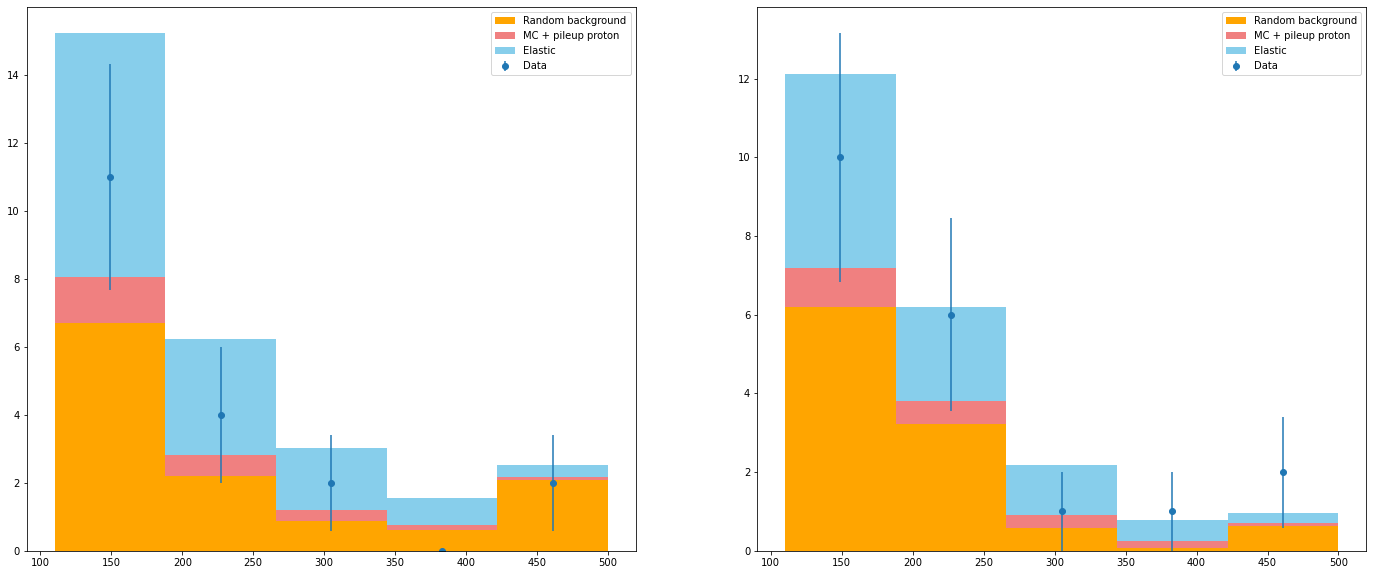

In [84]:
fig, axes = plt.subplots( 1, 2, figsize=(24,10) )

# fig_, ax_ = plot_data_mc( var_, hist_bins=hist_bins_, hist_range=hist_range_,
#                           df_data=df_data_sel_1,
#                           df_bkg=df_bkg_sel_1,
#                           df_sig_list=[ df_sig_list_sel_1[-1] ],
#                           df_mixed_list=[ df_mixed_list_sel_1[-1] ],
#                           weights_bkg=weights_bkg_sel_1,
#                           weights_sig_list=[ weights_sig_list_sel_1[-1] ],
#                           weights_mixed_list=[ weights_mixed_list_sel_1[-1] ],
#                           labels_mc=[ labels_mc[-1] ],
#                           fig=fig, ax=axes[0]
#                           )
# fig_, ax_ = plot_data_mc( var_, hist_bins=hist_bins_, hist_range=hist_range_,
#                           df_data=df_data_sel_2,
#                           df_bkg=df_bkg_sel_2,
#                           df_sig_list=[ df_sig_list_sel_2[-1] ],
#                           df_mixed_list=[ df_mixed_list_sel_2[-1] ],
#                           weights_bkg=weights_bkg_sel_2,
#                           weights_sig_list=[ weights_sig_list_sel_2[-1] ],
#                           weights_mixed_list=[ weights_mixed_list_sel_2[-1] ],
#                           labels_mc=[ labels_mc[-1] ],
#                           fig=fig, ax=axes[1]
#                           )

_, sumw_bkg_sub_el_1__, sumw2_bkg_sub_el_1__, sumw_mixed_el_1, sumw2_mixed_el_1 = calculate_mixed_bkg(
    var_, hist_bins_, hist_range_,
    df_bkg_sel_1, [ df_mixed_list_sel_1[-1] ],
    weights_bkg_sel_1, [ weights_mixed_list_sel_1[-1] ] )
print ( sumw_bkg_sub_el_1__, sumw2_bkg_sub_el_1__, sumw_mixed_el_1, sumw2_mixed_el_1 )
_, sumw_bkg_sub_el_2__, sumw2_bkg_sub_el_2__, sumw_mixed_el_2, sumw2_mixed_el_2 = calculate_mixed_bkg(
    var_, hist_bins_, hist_range_,
    df_bkg_sel_2, [ df_mixed_list_sel_2[-1] ],
    weights_bkg_sel_2, [ weights_mixed_list_sel_2[-1] ] )
print ( sumw_bkg_sub_el_2__, sumw2_bkg_sub_el_2__, sumw_mixed_el_2, sumw2_mixed_el_2 )

fig_, ax_ = plot_data_mc( hist_bins=hist_bins_, hist_range=hist_range_,
                          vals_data=df_data_sel_1[ var_ ],
                          vals_bkg=vals_bins_1,
                          vals_mixed=vals_bins_1,
                          vals_sig_list=[ df_sig_list_sel_1[-1][ var_ ] ],
                          weights_bkg=sumw_bkg_sub_1,
                          weights_mixed=sumw_mixed_el_1, 
                          weights_sig_list=[ weights_sig_list_sel_1[-1] ],
                          label_bkg="Random background",
                          label_mixed="MC + pileup proton",
                          labels_mc=[ labels_mc[-1] ],
                          colors=[ 'orange', 'lightcoral', 'skyblue' ],
                          fig=fig, ax=axes[0]
                          )
fig_, ax_ = plot_data_mc( hist_bins=hist_bins_, hist_range=hist_range_,
                          vals_data=df_data_sel_2[ var_ ],
                          vals_bkg=vals_bins_2,
                          vals_mixed=vals_bins_2,
                          vals_sig_list=[ df_sig_list_sel_2[-1][ var_ ] ],
                          weights_bkg=sumw_bkg_sub_2,
                          weights_mixed=sumw_mixed_el_2, 
                          weights_sig_list=[ weights_sig_list_sel_2[-1] ],
                          label_bkg="Random background",
                          label_mixed="MC + pileup proton",
                          labels_mc=[ labels_mc[-1] ],
                          colors=[ 'orange', 'lightcoral', 'skyblue' ],
                          fig=fig, ax=axes[1]
                          )